In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.sipm as sipm
import sipm.dataset as ds
from sipm.sipm import gauss, compound_poisson
from scipy.optimize import curve_fit
from scipy.special import erf, gamma
from scipy.signal import butter, lfilter
from scipy.signal import find_peaks

In [2]:
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def line(x,a,b):
    return a*x+b

def line_vbd(x,a,vbd):
    return a*(x-vbd)

# Top tile calibration (1101 data)

## Directories

In [4]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-01/'
bias = [61, 63, 65, 67, 69]
subdir = ['2022-11-01_volt_{}_pos_top_light_laser_coinc_none_cond_calibration/'.format(bias_) for bias_ in bias]

In [5]:
datasets_top = []
for subdir_ in subdir:
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4), samples=4000)
    for i in range(4):
        data.ch[i].read_data(header=True)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_integral(short=1.6, long=5)
        data.ch[i].ar_filter(tau=20)
        data.ch[i].get_famp()
        data.ch[i].clear()
    datasets_top.append(data)

## Plot charge histogram and analyze
Here we look at the raw waveform integrals over $1.6~\mu s$ ($I_{\rm short}$)

/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


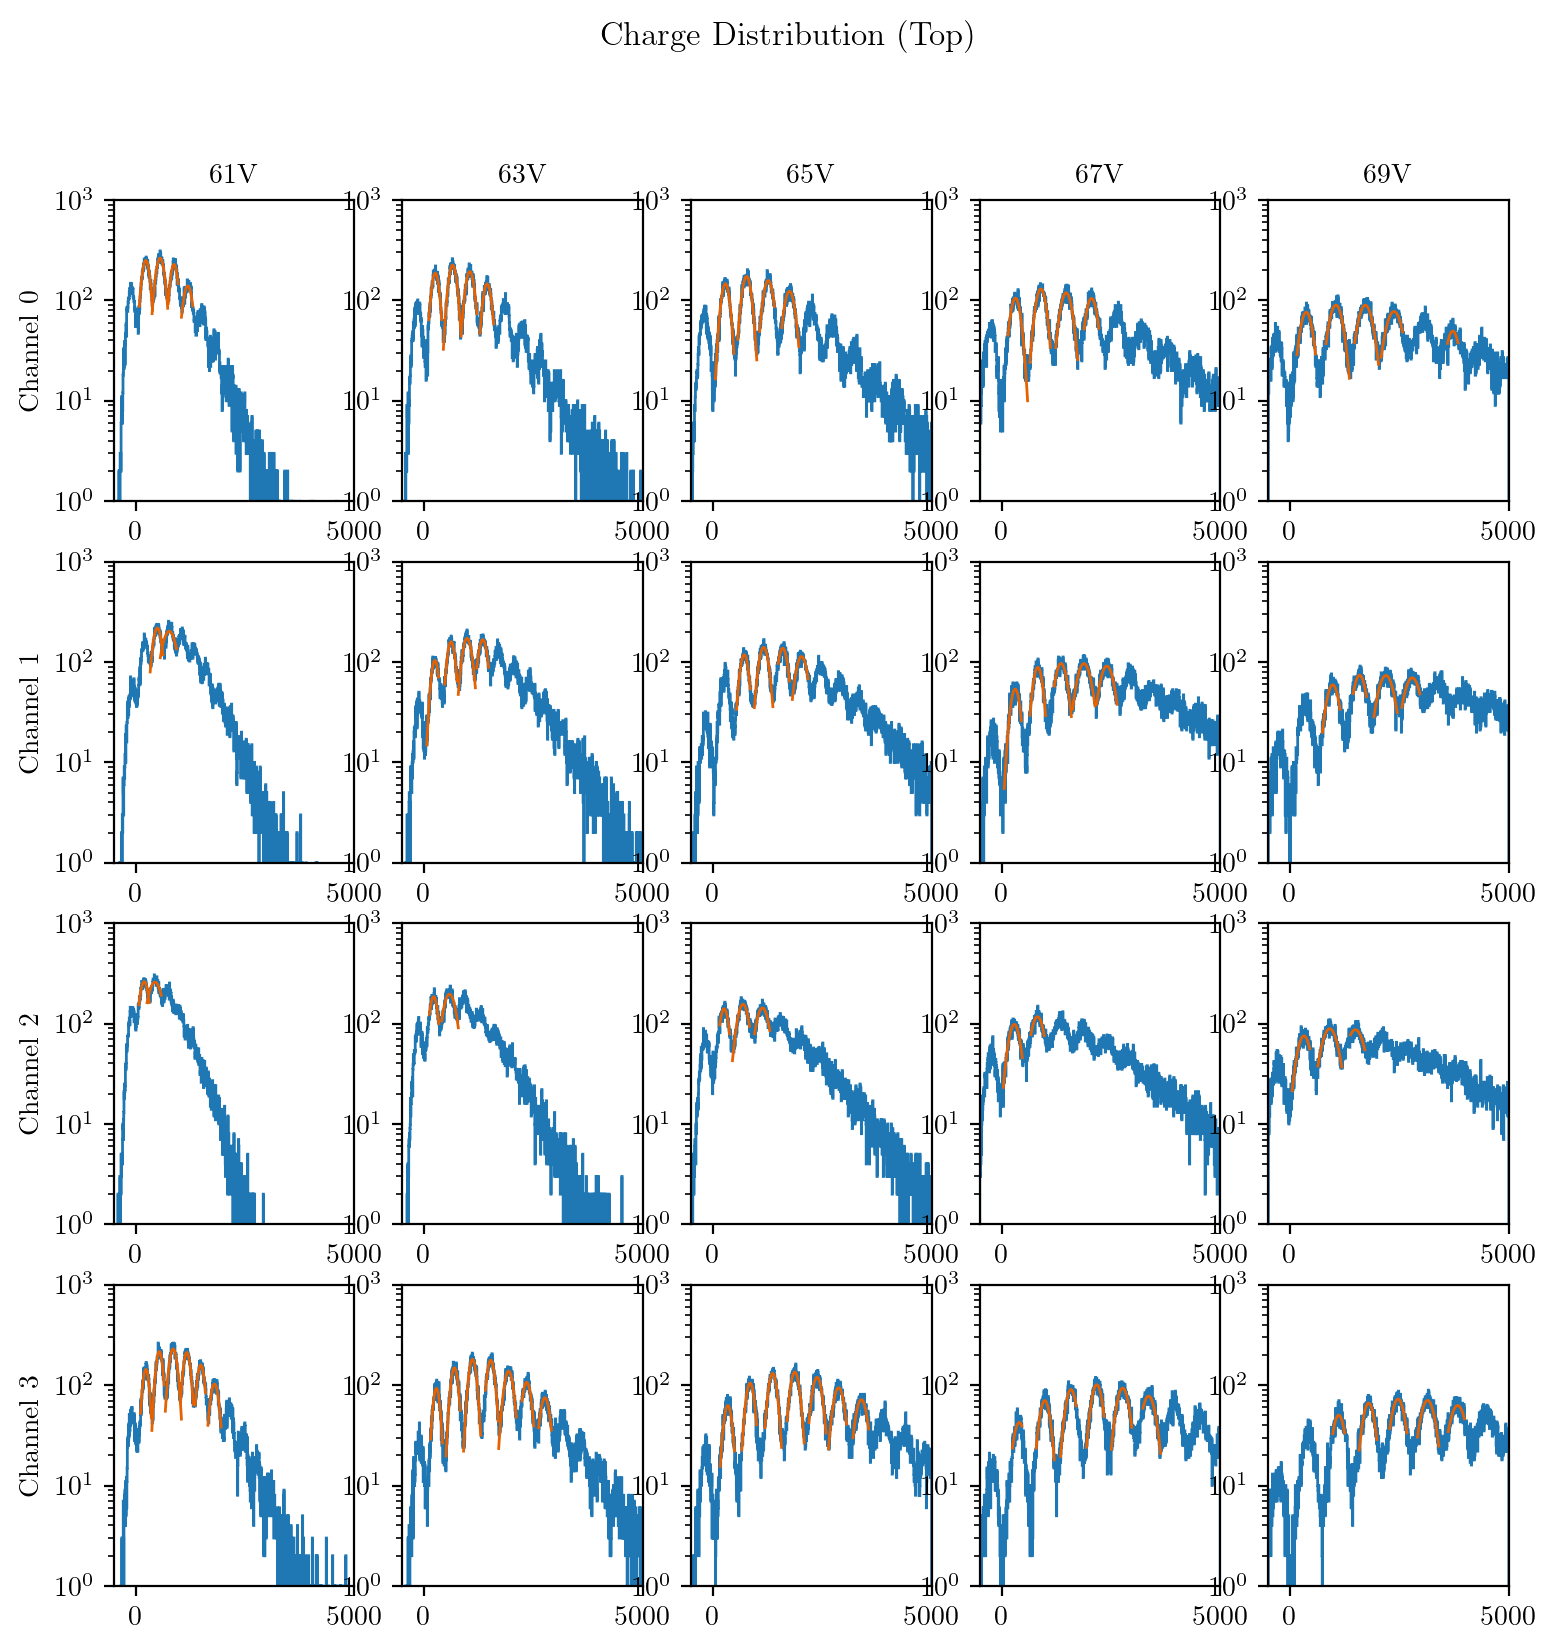

In [6]:
plt.figure(0,figsize=(9,9)) #for charge histograms
# plt.figure(1,figsize=(9,3)) #for breakdown voltage fit
# Vbd_charge_top = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets_top):
        #charge histogram
        data.ch[ch].get_integral_hist(short=[-5e2,5e3,1000], long=[-5e2,5e3,1000])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].integral_short_hist, data.ch[ch].integral_short_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].integral_short_hist_bin[0], data.ch[ch].integral_short_hist_bin[-1])
        plt.ylim(1, 1e3)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='integral_short', thre=100, prom=45, wid=20, dist=20)
        # fit pe peaks with Gaussian
        min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='integral_short')
        npe = len(data.ch[ch].integral_short_hist_fit)
        for ipe in range(npe):
            popt = [data.ch[ch].integral_short_hist_fit[ipe][ipar][0] for ipar in range(3)]
            plt.plot(data.ch[ch].integral_short_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].integral_short_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
        #fit pe-mean vs pe with linear
        Ishort = [[data.ch[ch].integral_short_hist_fit[k][1][0], data.ch[ch].integral_short_hist_fit[k][1][1]] for k in range(npe)]
        xlin = np.linspace(1,npe,npe)
        ylin = np.array(Ishort)[:,0]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Ishort)[:,1], maxfev=10000)
        data.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])])
    #breakdown voltage fit and plot
    # xlin = bias
    # ylin = [data.ch[ch].gain_integral[0] for data in datasets_top]
    # err = [data.ch[ch].gain_integral[1] for data in datasets_top]
    # popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], sigma=err, maxfev=10000)
    # print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    # Vbd_charge_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    # plt.figure(1)
    # plt.subplot(1,4,ch+1)
    # plt.title('Channel {}'.format(ch))
    # plt.ylabel('Gain (A.U.)')
    # plt.xlabel('Bias (V)')
    # plt.errorbar(xlin,ylin,yerr=err,fmt='o',markersize=2)
    # plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    # plt.xlim(50,80)
    # plt.ylim(0,1000)
        
plt.figure(0)
plt.suptitle('Charge Distribution (Top)')
plt.savefig('plots/sipm/charge_histo_top_1101.pdf')
# plt.figure(1)
# plt.suptitle('Breakdown Voltage (Top)')
# plt.savefig('plots/sipm/gain_bias_charge_top_1101.pdf')

## Plot filtered amplitude histogram and analyze
Here we look at the prompt amplitude of AR-filtered waveforms ($A_{\rm filt}$).<br>
The PE peaks in the histograms are fitted with Gaussian $(N_k, A_k, \sigma_k)$, where $k$ is PE count.<br>
$(k, A_k)$ is fitted with linear function $A_k = Q_A \times k  + b$.<br>
$(V, Q_A)$ is then fitted with linear function for breakdown voltage $Q_A = C(V-V_{bd})$.<br>
$(k, N_k)$ is fitted with Vinogradov model (Compound Poisson) where $\mu$ is laser intensity and $p$ is DiCT probability.<br>

mu=2.302 p=0.068
mu=2.530 p=0.142
mu=2.656 p=0.203
mu=2.763 p=0.255
mu=2.845 p=0.317
Channel 0 Vbd=54.995+/-0.062V slope=9.671+/-0.060
mu=3.083 p=0.116
mu=3.499 p=0.152
mu=3.722 p=0.196
mu=3.863 p=0.252
mu=3.924 p=0.302
Channel 1 Vbd=54.925+/-0.092V slope=8.688+/-0.083
mu=2.278 p=0.088
mu=2.580 p=0.140
mu=2.783 p=0.137
mu=2.759 p=0.253
mu=2.880 p=0.297
Channel 2 Vbd=55.082+/-0.092V slope=8.233+/-0.074
mu=3.318 p=0.101
mu=3.700 p=0.153
mu=3.907 p=0.205
mu=4.085 p=0.266
mu=3.200 p=0.424
Channel 3 Vbd=54.836+/-0.100V slope=9.560+/-0.086


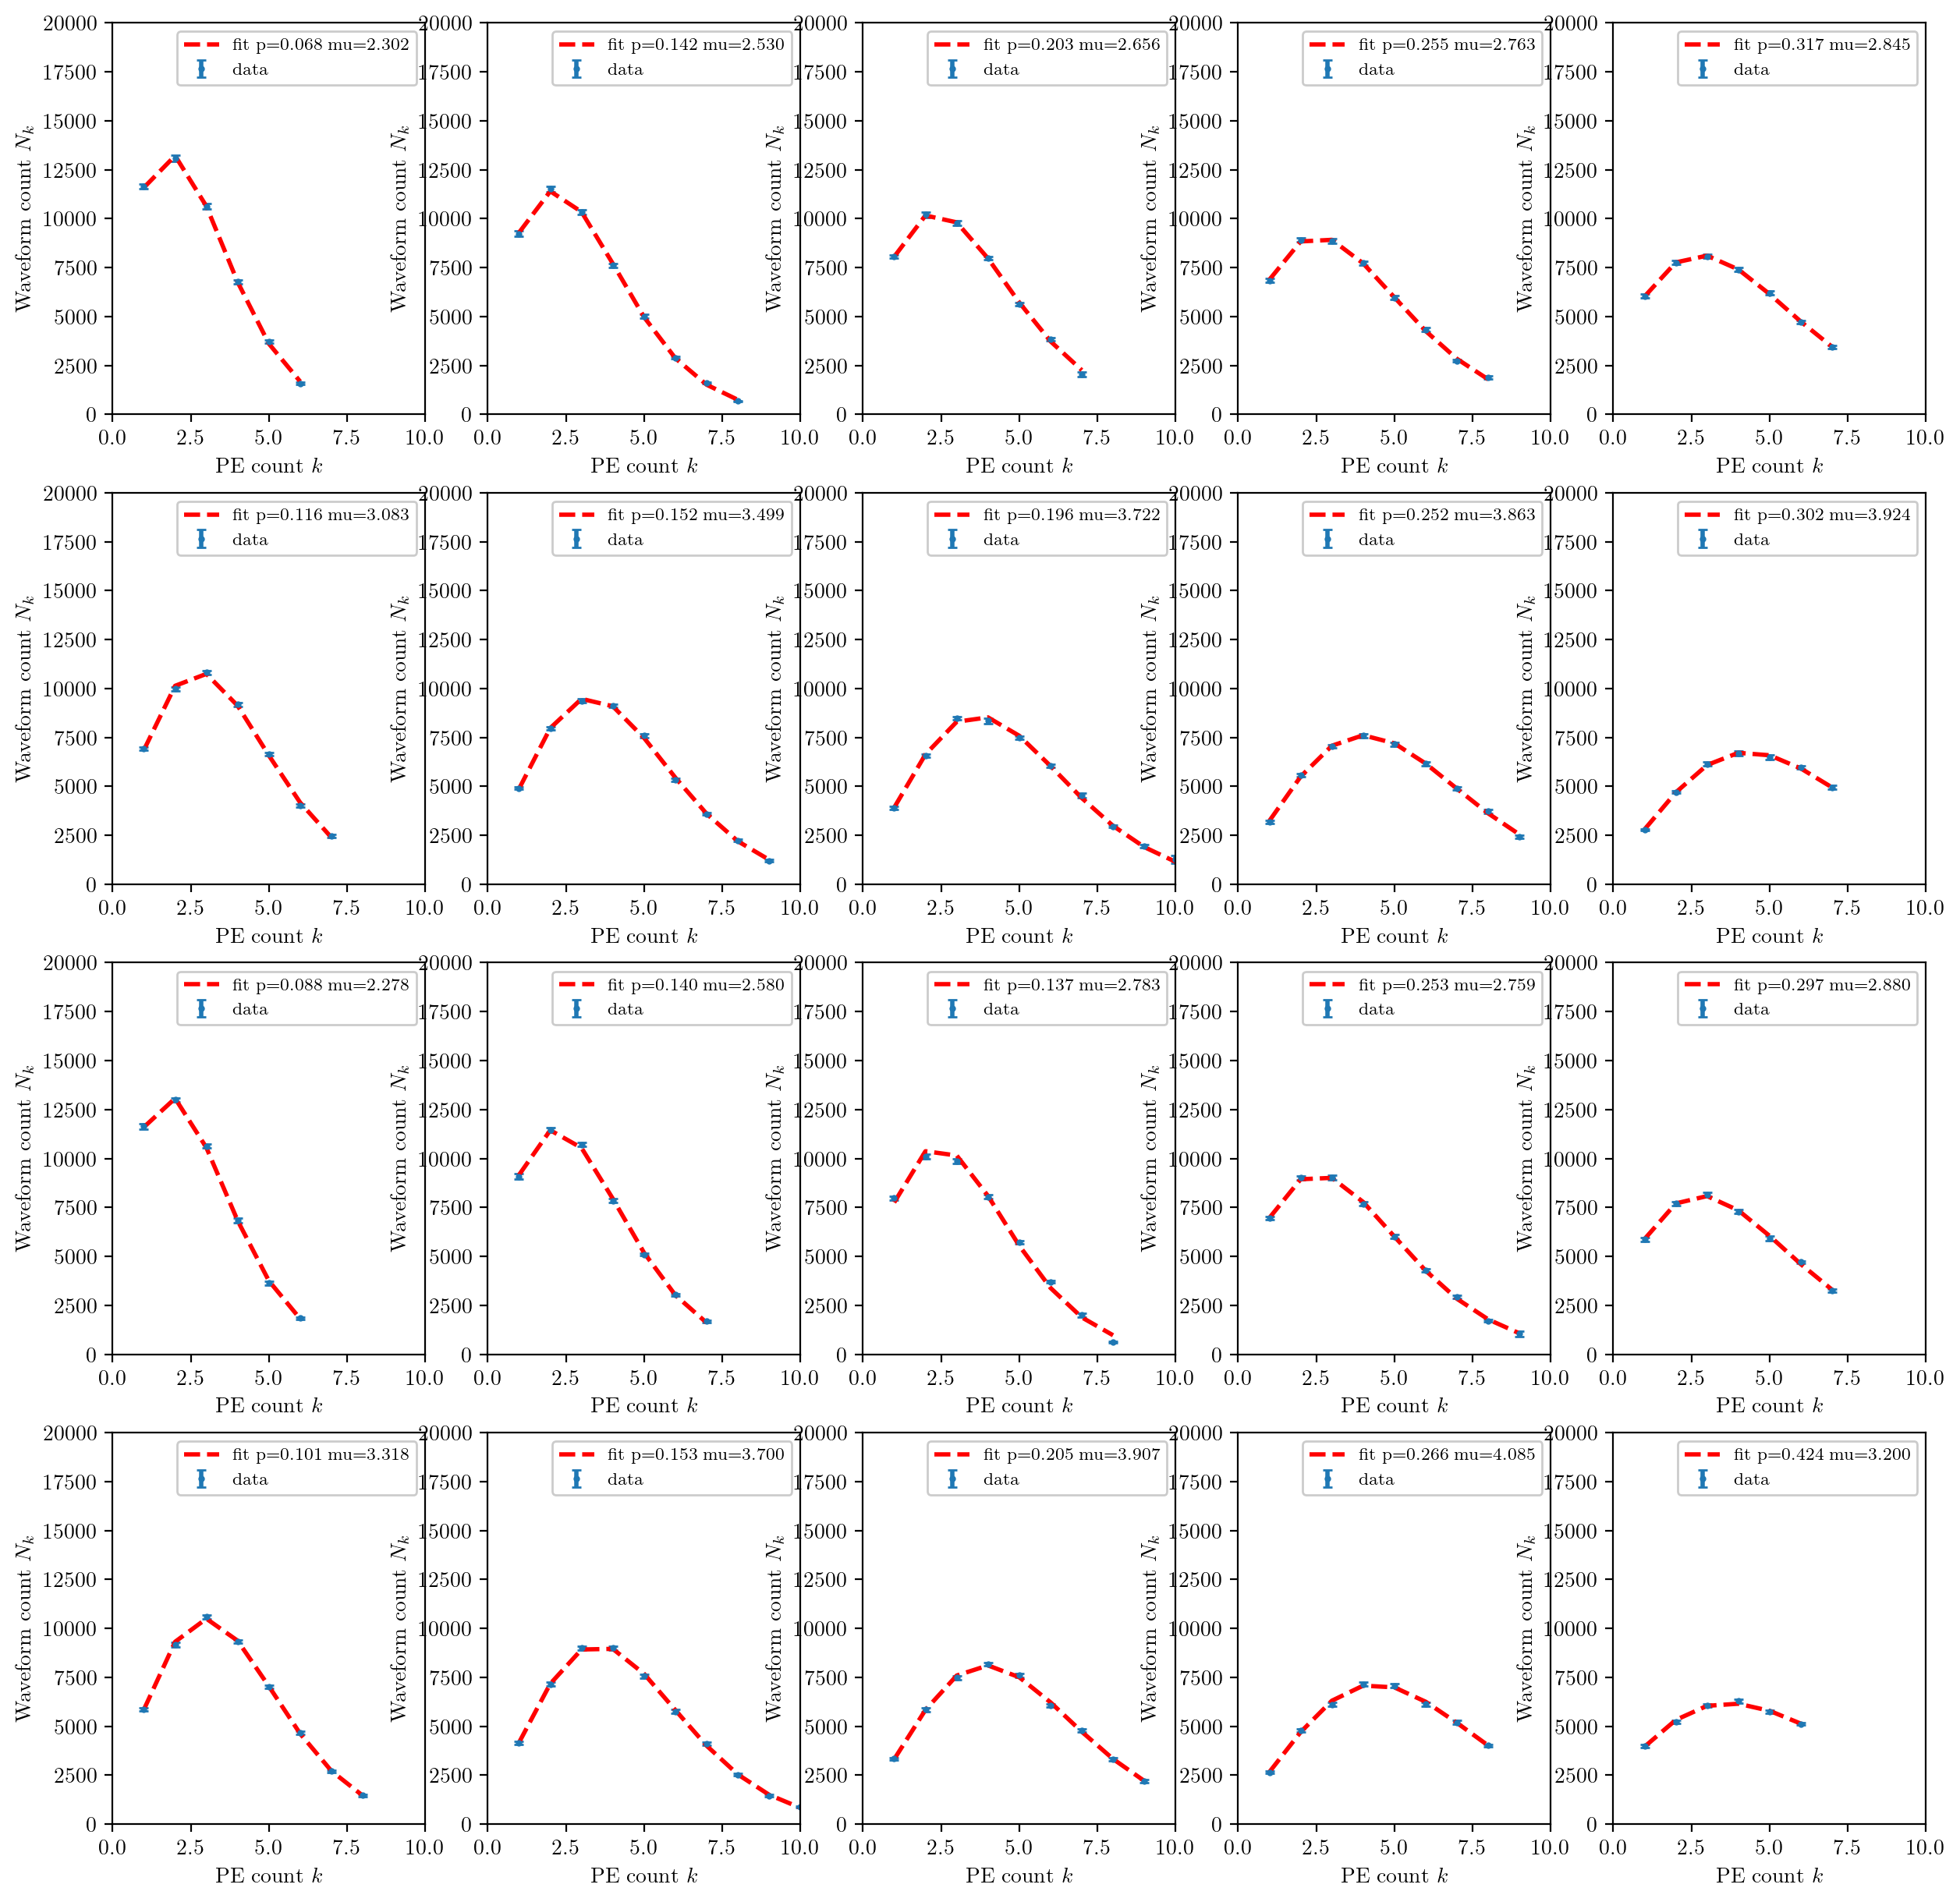

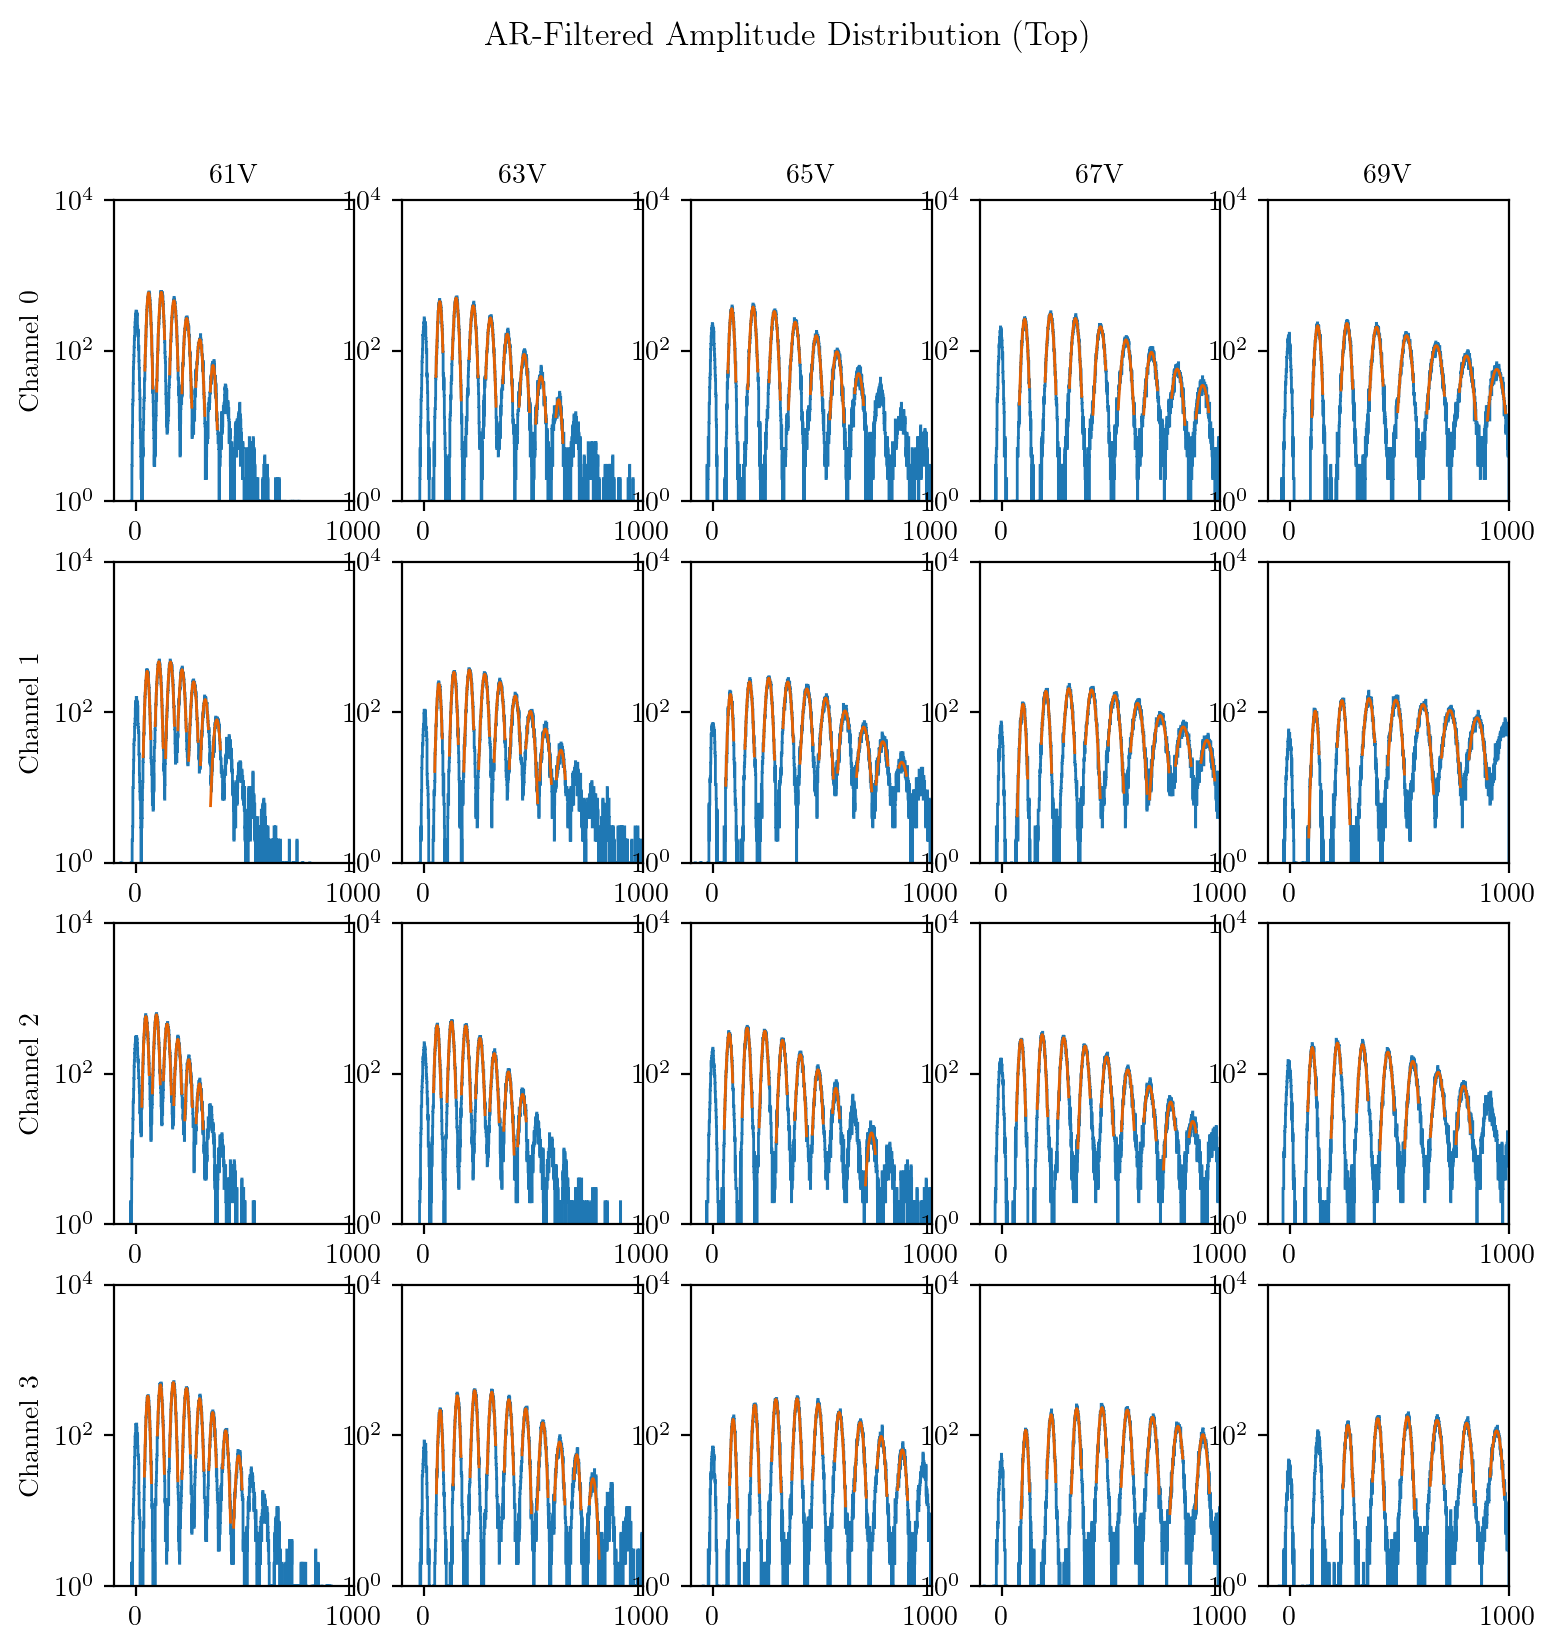

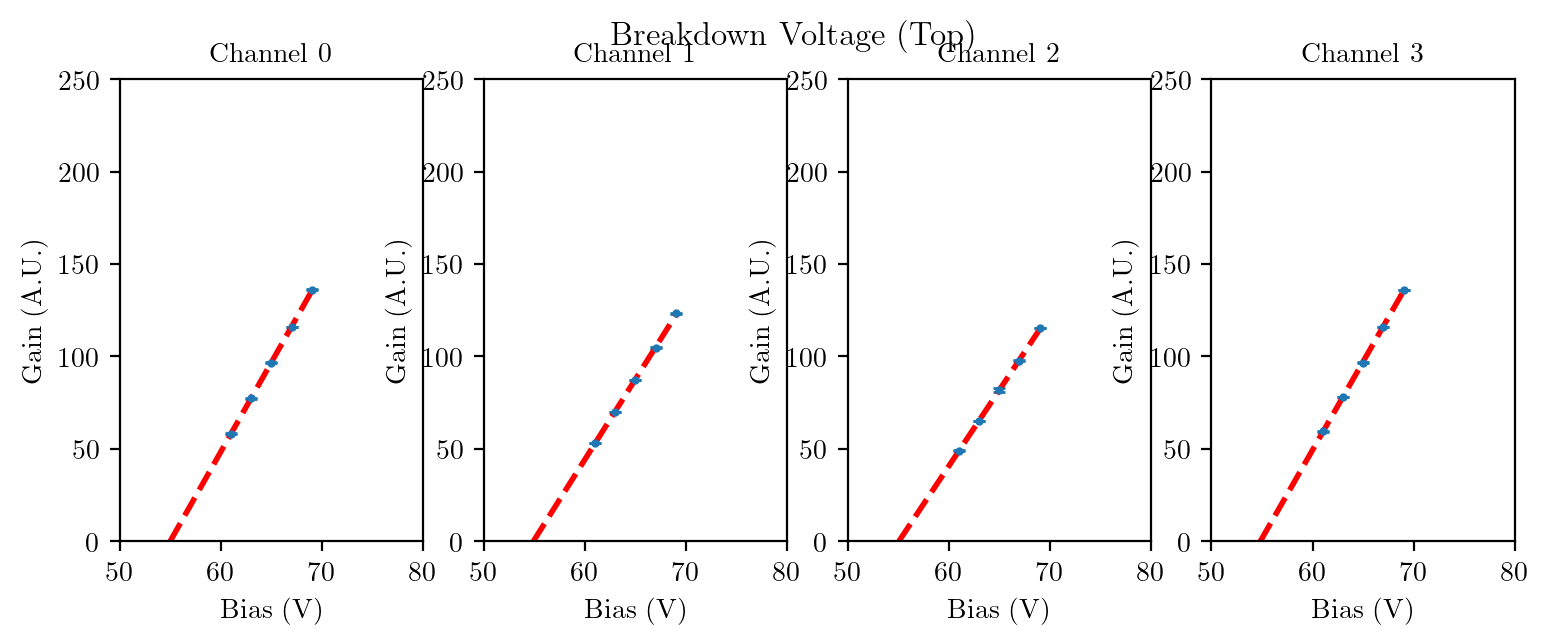

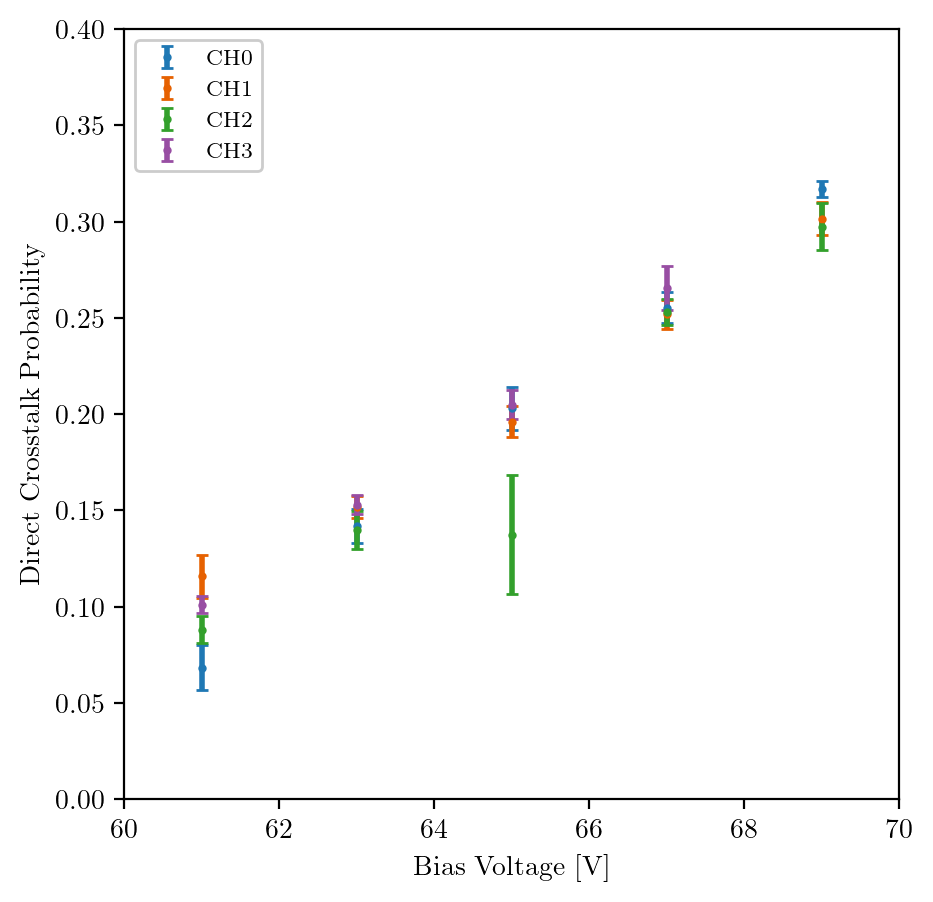

In [7]:
plt.figure(0,figsize=(9,9)) # for filtered amplitude histograms
plt.figure(1,figsize=(9,3)) # for breakdown voltage fit
plt.figure(2,figsize=(15,15)) # for Vinogradov fit
plt.figure(3,figsize=(5,5)) # for crosstalk summary
Vbd_famp_top = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets_top):  
        #filtered amplitude histogram
        data.ch[ch].get_famp_hist(bin=[-1e2,1e3,1000])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='famp', thre=100, prom=8, wid=15, dist=10)
        # fit pe peaks with Gaussian
        min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='famp')
        npe = len(data.ch[ch].famp_hist_fit)
        for ipe in range(npe):
            popt = [data.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
            plt.plot(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
        #fit pe-mean vs pe with linear
        Afilt = [[data.ch[ch].famp_hist_fit[k][1][0], data.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
        xlin = np.linspace(1,npe,npe)
        ylin = np.array(Afilt)[:,0]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
        data.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
        #Vinogradov fit
        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        N_k = [data.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
        plt.errorbar(np.arange(1,len(N_k)+1), np.array(N_k)[:,0], yerr=np.array(N_k)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(N_k)+1)), np.array(N_k)[:,0], p0=[data.ch[ch].nevents, 2, 0.2], sigma=np.array(N_k)[:,1], maxfev=10000)
        print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
        data.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
        plt.plot(np.arange(1,len(N_k)+1), compound_poisson(np.arange(1,len(N_k)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
        plt.ylim(0,0.4*data.ch[ch].nevents)
        plt.xlim(0,10)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'Waveform count $N_k$')
        plt.legend(loc='upper right')
    # plot crosstalk
    plt.figure(3)
    plt.errorbar(bias, [data.ch[ch].ct[0] for data in datasets_top], yerr=[data.ch[ch].ct[1] for data in datasets_top], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_a[0] for data in datasets_top]
    err = [data.ch[ch].q_a[1] for data in datasets_top]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        

plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Top)')
plt.savefig('plots/sipm/famp_histo_top_1101.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Top)')
plt.savefig('plots/sipm/gain_bias_famp_top_1101.pdf')
plt.figure(3)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Direct Crosstalk Probability')
plt.xlim(60,70)
plt.ylim(0, 0.4)
plt.savefig('plots/sipm/dict_top_1101.pdf')

## Afterpulsing
Here we look at the raw waveform integrals over $5~\mu s$ ($I_{\rm long}$).<br>
They are grouped by the prompt filtered amplitude $A_{\rm filt}$.<br>
If $|A_{\rm filt}-A_k|<3\sigma_k$, assign $I_{\rm long}$ to $I_k$.<br>
$I_k$ is fitted by a Gaussian $(N_{k,\rm peak}, I_{k,\rm peak}, \sigma_{k,\rm peak})$.<br>
$(k, I_k)$ is fitted by a linear function $I_{k,\rm peak} = Q_{\rm peak}\times k + b$.<br>
Define $I_{k,\rm avg}\equiv \overline{I_{k}}$.<br>
$(k, I_{k, \rm avg})$ is fitted by a linear function $I_{k, \rm avg} = Q_{\rm avg} \times k + b$.<br>
Define afterpulse charge $Q_{\rm AP} \equiv \frac{Q_{\rm avg}}{Q_{\rm peak}}-1$.<br>
$Q_{\rm peak}$ is then fitted by the linear function for breakdown voltage $Q_{\rm peak} = C(V-V_{bd})$.<br>

Channel 0 Vbd=53.756+/-0.266V slope=46.873+/-1.070
Channel 1 Vbd=53.596+/-0.173V slope=45.739+/-0.724
Channel 2 Vbd=53.806+/-0.161V slope=45.085+/-0.540


/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:803: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Channel 3 Vbd=53.718+/-0.215V slope=46.054+/-0.941


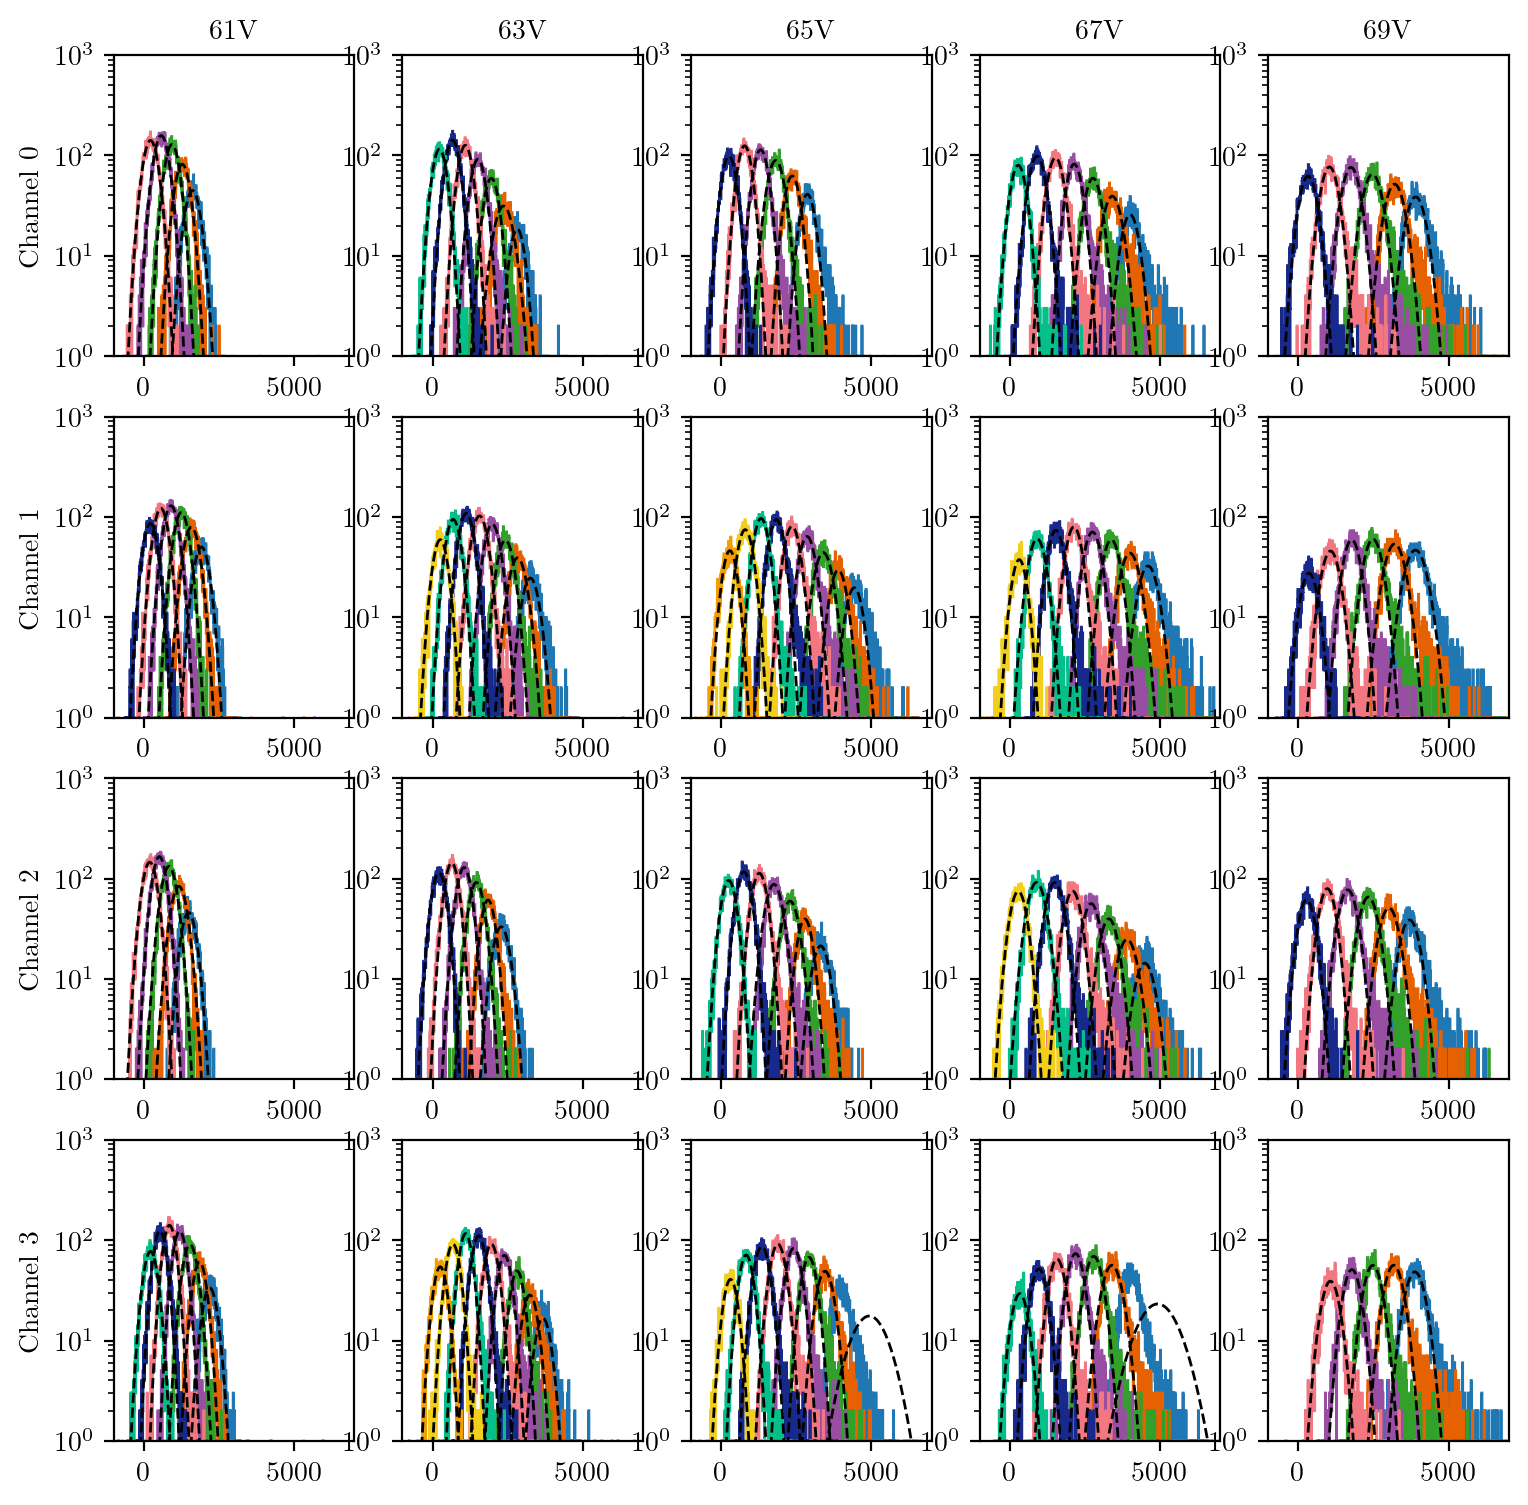

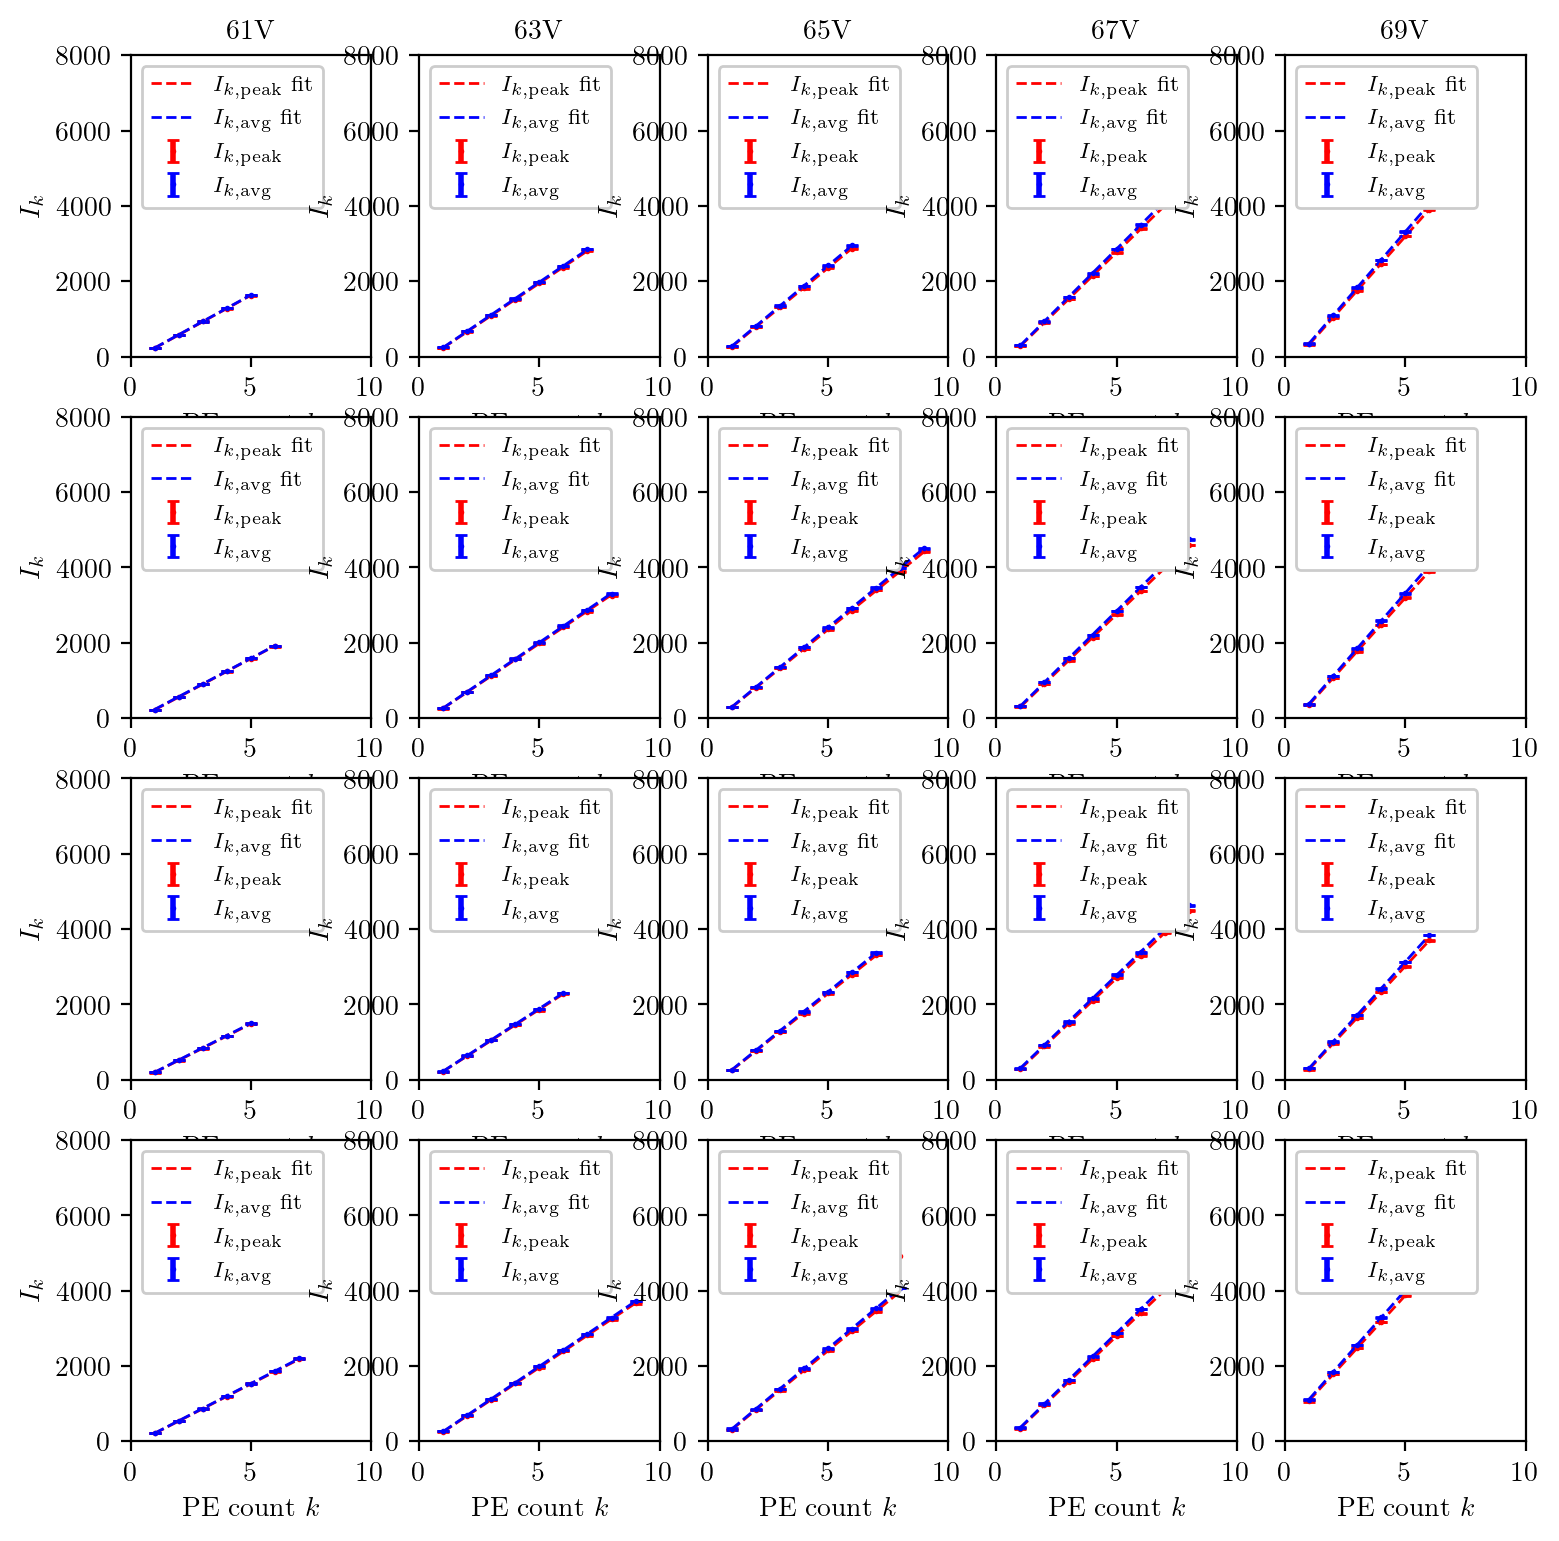

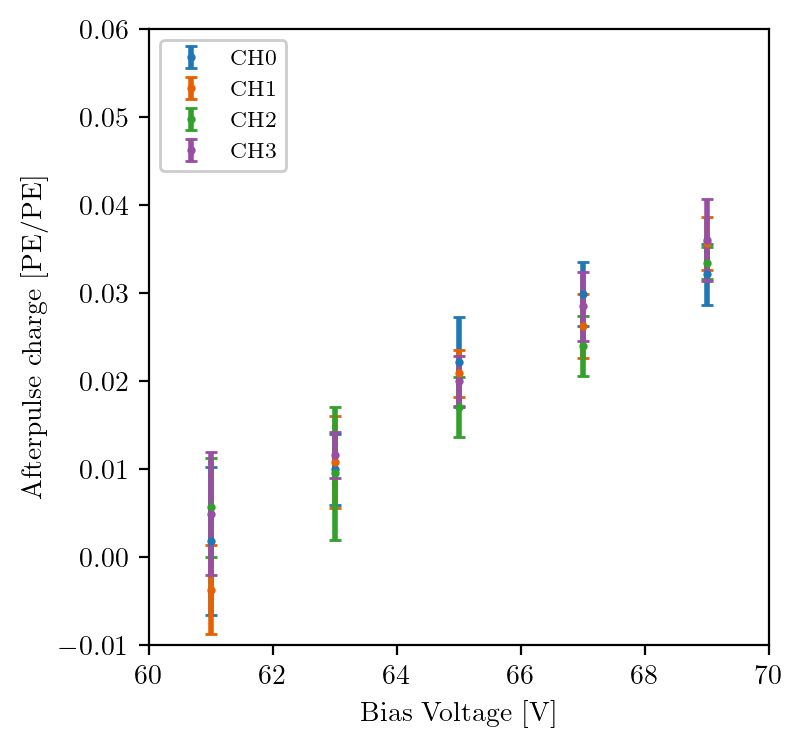

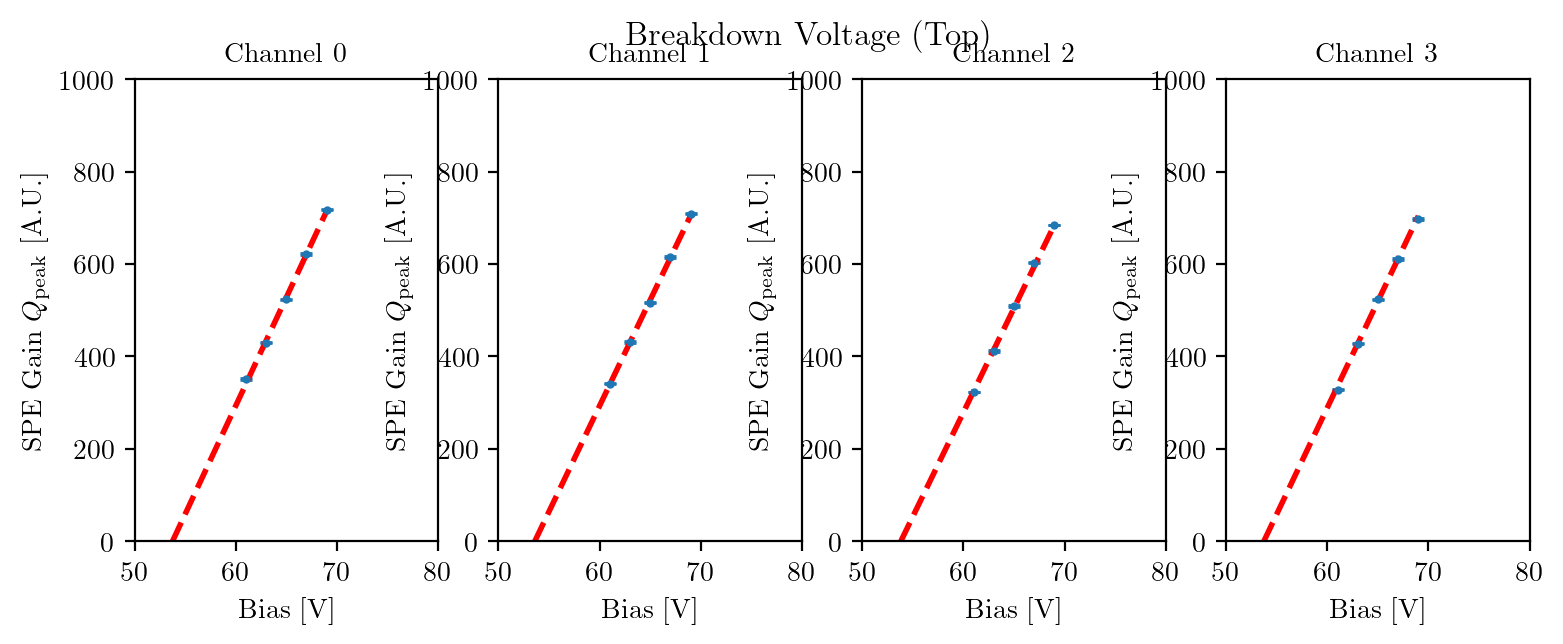

In [8]:
plt.figure(0,figsize=(9,9)) # for I_k histograms
plt.figure(1,figsize=(9,9)) # for I_k fits
plt.figure(2,figsize=(4,4)) # for afterpulse
plt.figure(3,figsize=(9,3)) # for Vbd
Vbd_charge_top = np.zeros((4,2))
x_min=-1000
x_max=7000
n_bins=1000
bin_width = (x_max-x_min)/n_bins
for ch in range(4):
    for i,data in enumerate(datasets_top):
        Ik_peak = [] 
        Ik_avg = []
        data.ch[ch].get_afterpulse_charge(nsigma=3, bin=[x_min, x_max, n_bins])
        
        #histogram and Gaussian fit
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        for j in np.arange(len(data.ch[ch].ap_charge)-2,-1,-1):
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            Ik_avg.append([np.mean(data.ch[ch].ap_charge[j]), np.std(data.ch[ch].ap_charge[j])/np.sqrt(len(data.ch[ch].ap_charge[j]))])
            w = int(np.std(data.ch[ch].ap_charge[j])/bin_width) # in bins
            p = np.argmax(data.ch[ch].ap_charge_hist[j]) # in bins
            if w>0.3*(p+x_min/bin_width):
                w=40 # something weird happened so I need to do this
            popt,pcov = curve_fit(gauss, data.ch[ch].ap_charge_hist_bin[j][p-w:p+w], data.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(data.ch[ch].ap_charge_hist[j])*w*bin_width,p*bin_width,w*bin_width], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
            Ik_peak.append([popt[1],np.sqrt(pcov[1,1])])
        plt.xlim(data.ch[ch].ap_charge_hist_bin[0][0], data.ch[ch].ap_charge_hist_bin[0][-1])
        plt.ylim(1,1e3)
        plt.yscale('log')
        # plot mu-pe vs avg-pe
        Ik_peak = list(reversed(Ik_peak))
        Ik_avg = list(reversed(Ik_avg))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        # Q_peak fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
        popt,pcov=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
        # print('Q_peak = {:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0])))
        data.ch[ch].set_spe_gain(q_peak=[popt[0],np.sqrt(pcov[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        # Q_avg fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
        popt_,pcov_=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1,np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
        # print('Q_avg = {:.3f}+/-{:.3f}'.format(popt_[0], np.sqrt(pcov_[0,0])))
        data.ch[ch].set_spe_gain(q_avg=[popt_[0],np.sqrt(pcov_[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'$I_k$')
        data.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])
        plt.xlim(0,10)
        plt.ylim(0,8000)
        plt.legend()
    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in datasets_top], yerr=[data.ch[ch].ap[1] for data in datasets_top], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_peak[0] for data in datasets_top]
    err = [data.ch[ch].q_peak[1] for data in datasets_top]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_top[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(3)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel(r'SPE Gain $Q_{\rm peak}$ [A.U.]')
    plt.xlabel('Bias [V]')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)

plt.figure(2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(60,70)
plt.ylim(-0.01, 0.06)
plt.savefig('plots/sipm/afterpulse_bias_top_1101.pdf')
plt.figure(3)
plt.suptitle('Breakdown Voltage (Top)')
plt.savefig('plots/sipm/gain_bias_charge_top_1101.pdf')

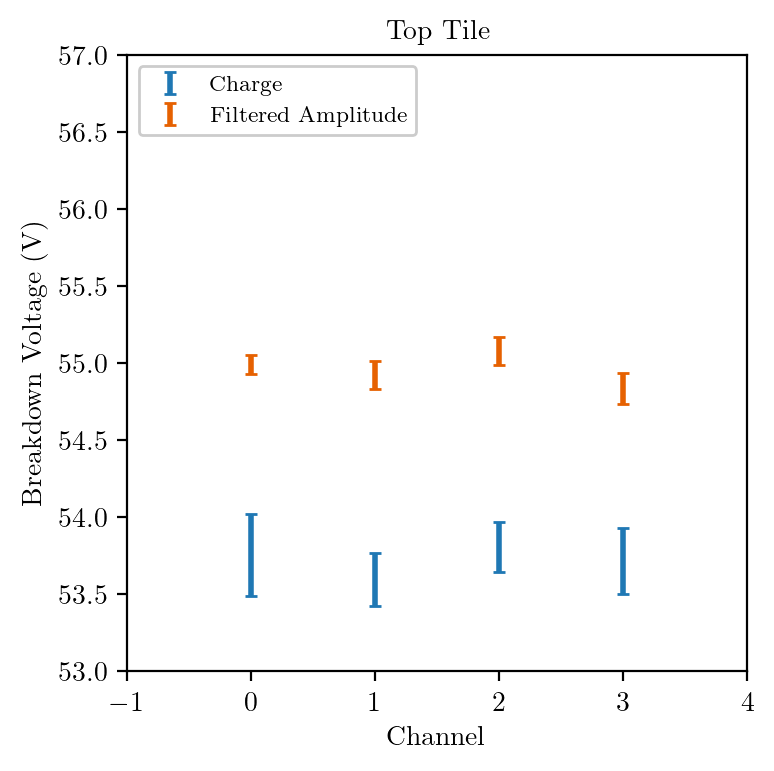

<Figure size 800x600 with 0 Axes>

In [9]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_top[:,0], yerr=Vbd_charge_top[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_top[:,0], yerr=Vbd_famp_top[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(53,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Top Tile')
plt.legend()
plt.show()
plt.savefig('plots/sipm/vbd_top_1101.pdf')

## SPE average waveform
Take waveforms with prompt filtered amplitude $|A-A_k|<2\sigma_k$ for $k=1$ and take average.<br>
At $k=1$ PE, afterpulses can be ignored.<br>
The average waveform is fitted by
$$h(t,t') = A_1 e^{-(t-t')/\tau_1} + A_2 e^{-(t-t')/\tau2}$$

# Try to include time jitter
SiPM pulse (single component):
$$h(t,t') = A e^{-\frac{t-t'}{\tau}} \Theta(t-t')$$
Time jitter:
$$g(t') = \frac{1}{\sigma \sqrt{2\pi}} e^{-\frac{(t'-t_0)^2}{2\sigma^2}}$$
Average waveform:
$$
f(t,t') = \int g(t') h(t,t') \, dt'
= \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{(t'-t_0)^2}{2\sigma^2}-\frac{t-t'}{\tau}} \, dt'$$

$$ = \frac{A}{\sigma\sqrt{2\pi}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t^{'2} - 2t'(t_0 + \sigma^2/\tau) + t_0^2 + 2\sigma^2 t_0/\tau + \sigma^4 /\tau^2 + 2\sigma^2 (t-t_0)/\tau - \sigma^4/\tau^2]} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sigma\sqrt{2\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t} e^{-\frac{1}{2\sigma^2}[t'-(t_0 + \sigma^2/\tau)]^2} \, dt'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{\sqrt{\pi}} e^{-\frac{t-t_0}{\tau}} \int_{-\infty}^{t/\sigma\sqrt{2}} e^{-[x'-\frac{t_0 + \sigma^2/\tau}{\sigma\sqrt{2}}]^2} \, dx'
$$

$$
= \frac{Ae^{\frac{\sigma^2}{2\tau^2}}}{2} e^{-\frac{t-t_0}{\tau}} \left[1 + erf\left(\frac{t-t_0-\sigma^2/\tau}{\sigma\sqrt{2}}\right)\right]
$$

CH0 61V  A1=3.069+/-0.029 TAU1=0.2955+/-0.0028us A2=2.181+/-0.103 TAU2=0.0271+/-0.0019us sigma=0.0072+/-0.0002us t0=6.327+/-0.000us
CH0 63V  A1=3.754+/-0.029 TAU1=0.2704+/-0.0021us A2=3.065+/-0.129 TAU2=0.0231+/-0.0013us sigma=0.0076+/-0.0002us t0=6.327+/-0.000us
CH0 65V  A1=4.785+/-0.033 TAU1=0.2447+/-0.0017us A2=4.074+/-0.192 TAU2=0.0196+/-0.0011us sigma=0.0079+/-0.0002us t0=6.328+/-0.000us
CH0 67V  A1=5.921+/-0.049 TAU1=0.2220+/-0.0018us A2=5.379+/-0.242 TAU2=0.0200+/-0.0012us sigma=0.0080+/-0.0002us t0=6.328+/-0.000us
CH0 69V  A1=7.731+/-0.064 TAU1=0.2015+/-0.0017us A2=5.393+/-0.430 TAU2=0.0170+/-0.0016us sigma=0.0080+/-0.0002us t0=6.328+/-0.000us
CH1 61V  A1=0.975+/-0.042 TAU1=0.6282+/-0.0220us A2=3.087+/-0.044 TAU2=0.0980+/-0.0029us sigma=0.0057+/-0.0002us t0=6.325+/-0.000us
CH1 63V  A1=1.222+/-0.052 TAU1=0.5723+/-0.0191us A2=4.112+/-0.052 TAU2=0.0950+/-0.0025us sigma=0.0061+/-0.0002us t0=6.326+/-0.000us
CH1 65V  A1=1.667+/-0.073 TAU1=0.4772+/-0.0153us A2=4.903+/-0.070 TAU2=0.085

/home/as111/sipm-analysis/sipm/sipm.py:25: RuntimeWarning: overflow encountered in exp
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2
/home/as111/sipm-analysis/sipm/sipm.py:25: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(sigma**2/2/tau**2)*np.exp(-(t-t0)/tau)*(1+erf((t-t0-sigma**2/tau)/sigma/np.sqrt(2)))/2


CH3 69V  A1=15.088+/-0.058 TAU1=0.3153+/-0.0015us A2=11.791+/-1.127 TAU2=0.0124+/-0.0011us sigma=0.0077+/-0.0002us t0=6.327+/-0.000us


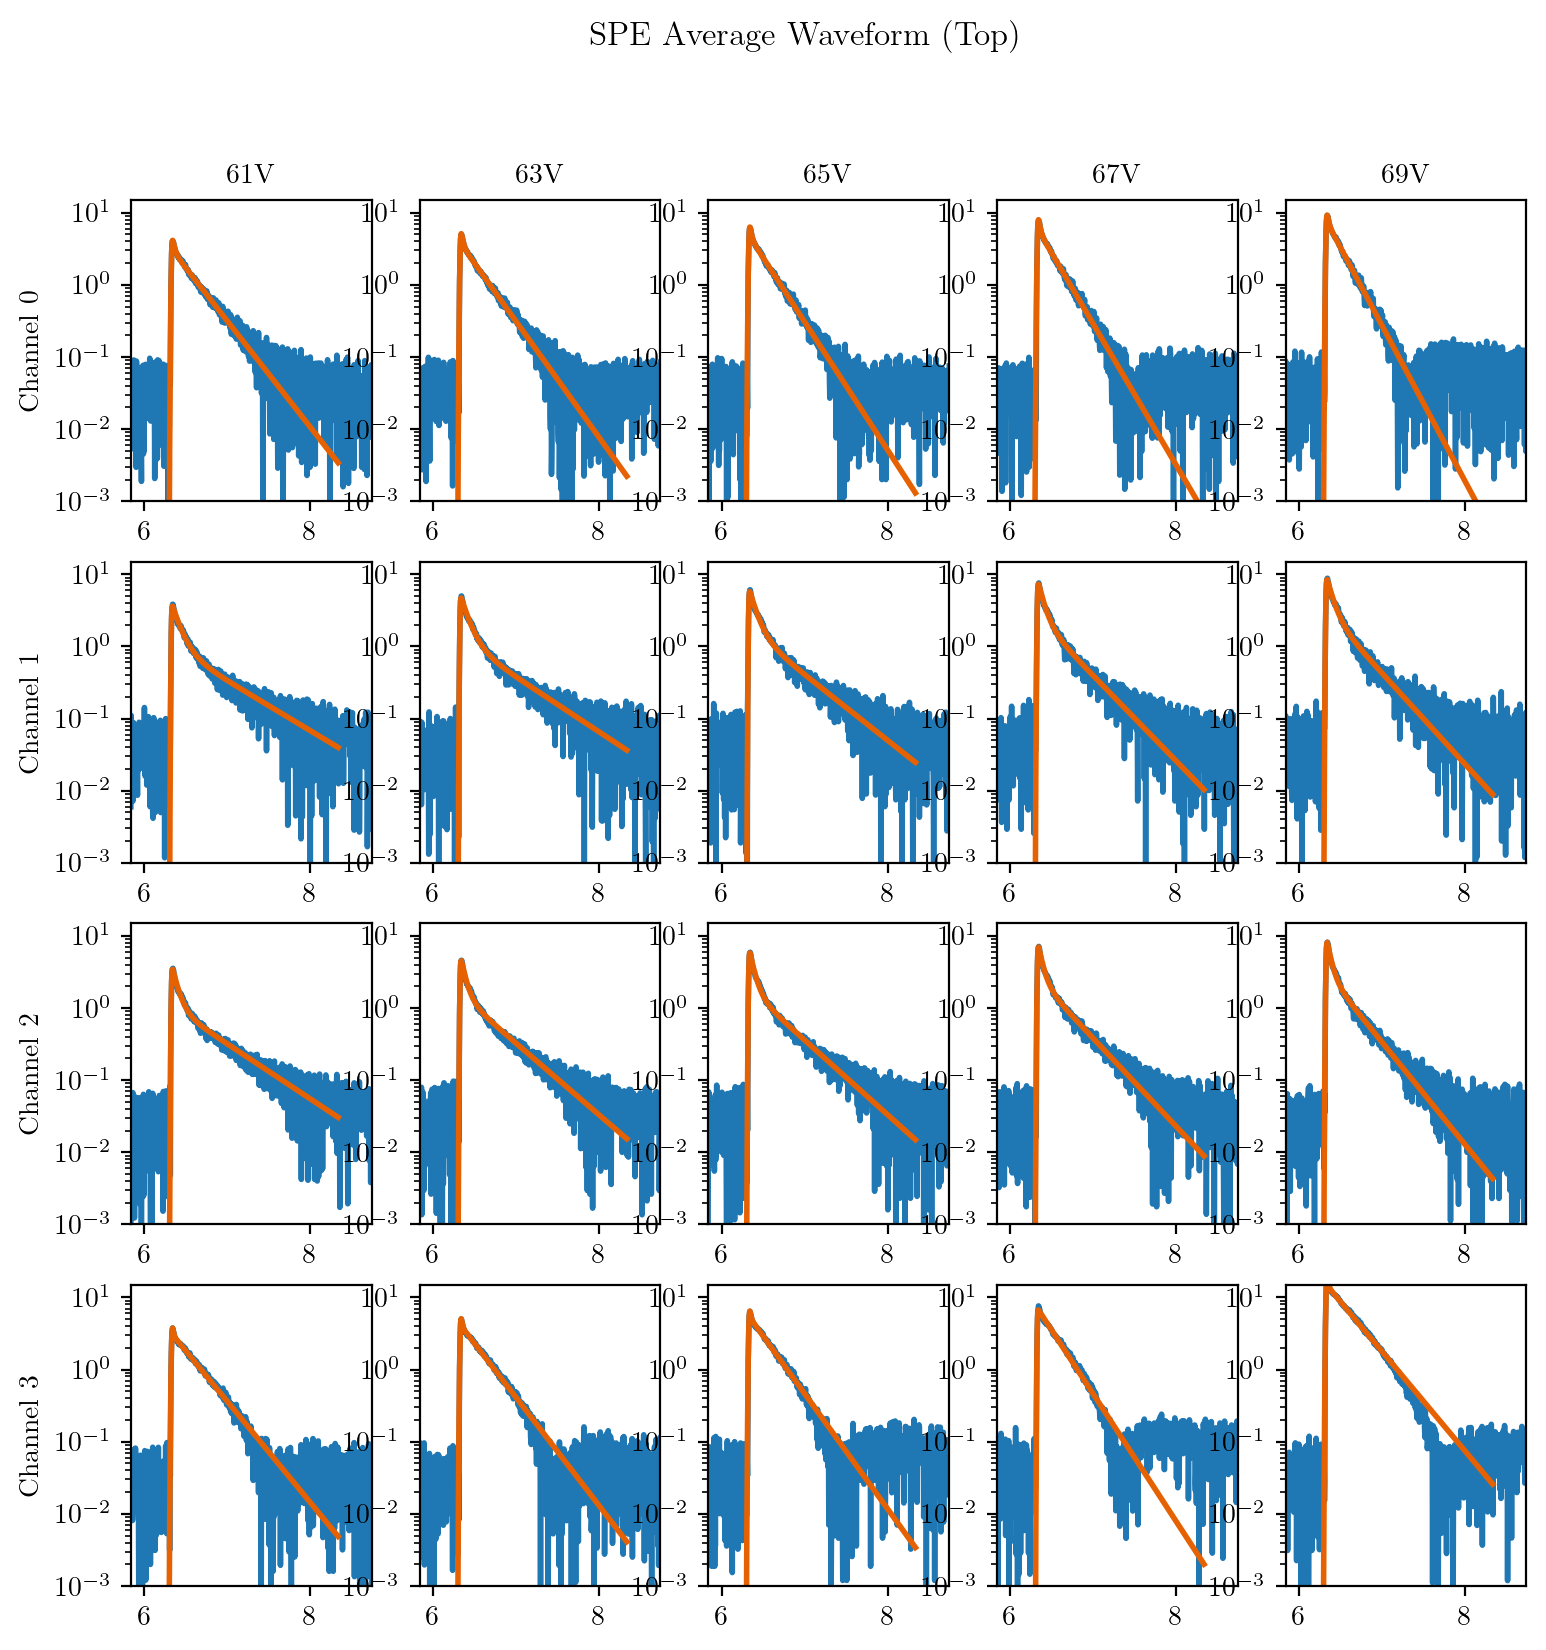

In [10]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
for ch in range(4):
    spe_integral = []
    for i,data in enumerate(datasets_top):
        data.ch[ch].get_spe_avgwf()
        data.ch[ch].clear()
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(data.ch[ch].time, abs(data.ch[ch].spe_avgwf))
        err = np.std(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])
        t_start = int(data.ch[ch].trigger_position - 0.1/data.ch[ch].sample_step)
        t_end = int(data.ch[ch].trigger_position + 2/data.ch[ch].sample_step)
        popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[t_start:t_end], data.ch[ch].spe_avgwf[t_start:t_end], p0=[4.8,0.25,4.0,0.02,0.008,6.33], sigma=[err]*len(data.ch[ch].time[t_start:t_end]), maxfev=10000)
        plt.plot(data.ch[ch].time[t_start:t_end], data.ch[ch].get_pulse_shape(data.ch[ch].time[t_start:t_end],*popt))
        print('CH{} {}V  A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,bias[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        data.ch[ch].set_pulse_pars(a1=popt[0], tau1=popt[1], a2=popt[2], tau2=popt[3])
        plt.xlim((t_start-100)*data.ch[ch].sample_step,(t_end+100)*data.ch[ch].sample_step)
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Top)')
plt.savefig('plots/sipm/spewf_top_1101.pdf')

# Bottome tile calibration (1103 data)

## Directories

In [11]:
data_dir = '/scratch/gpfs/GALBIATI/data/sipm/reflector_studies/2022-11-03/'
bias = [61, 63, 65, 67, 69]
subdir = ['2022-11-03_volt_{}_pos_bottom_light_laser_coinc_none_cond_calibration/'.format(bias_) for bias_ in bias]

In [12]:
datasets_bot = []
for subdir_ in subdir:
    path = "{}{}".format(data_dir, subdir_)
    data = ds.Dataset(path, pol=-1, channels=range(4), samples=4000)
    for i in range(4):
        data.ch[i].read_data(header=True)
        data.ch[i].baseline_subtraction()
        data.ch[i].get_integral(short=1.6, long=5)
        data.ch[i].ar_filter(tau=20)
        data.ch[i].get_famp()
        data.ch[i].clear()
    datasets_bot.append(data)

## Plot charge histogram and analyze

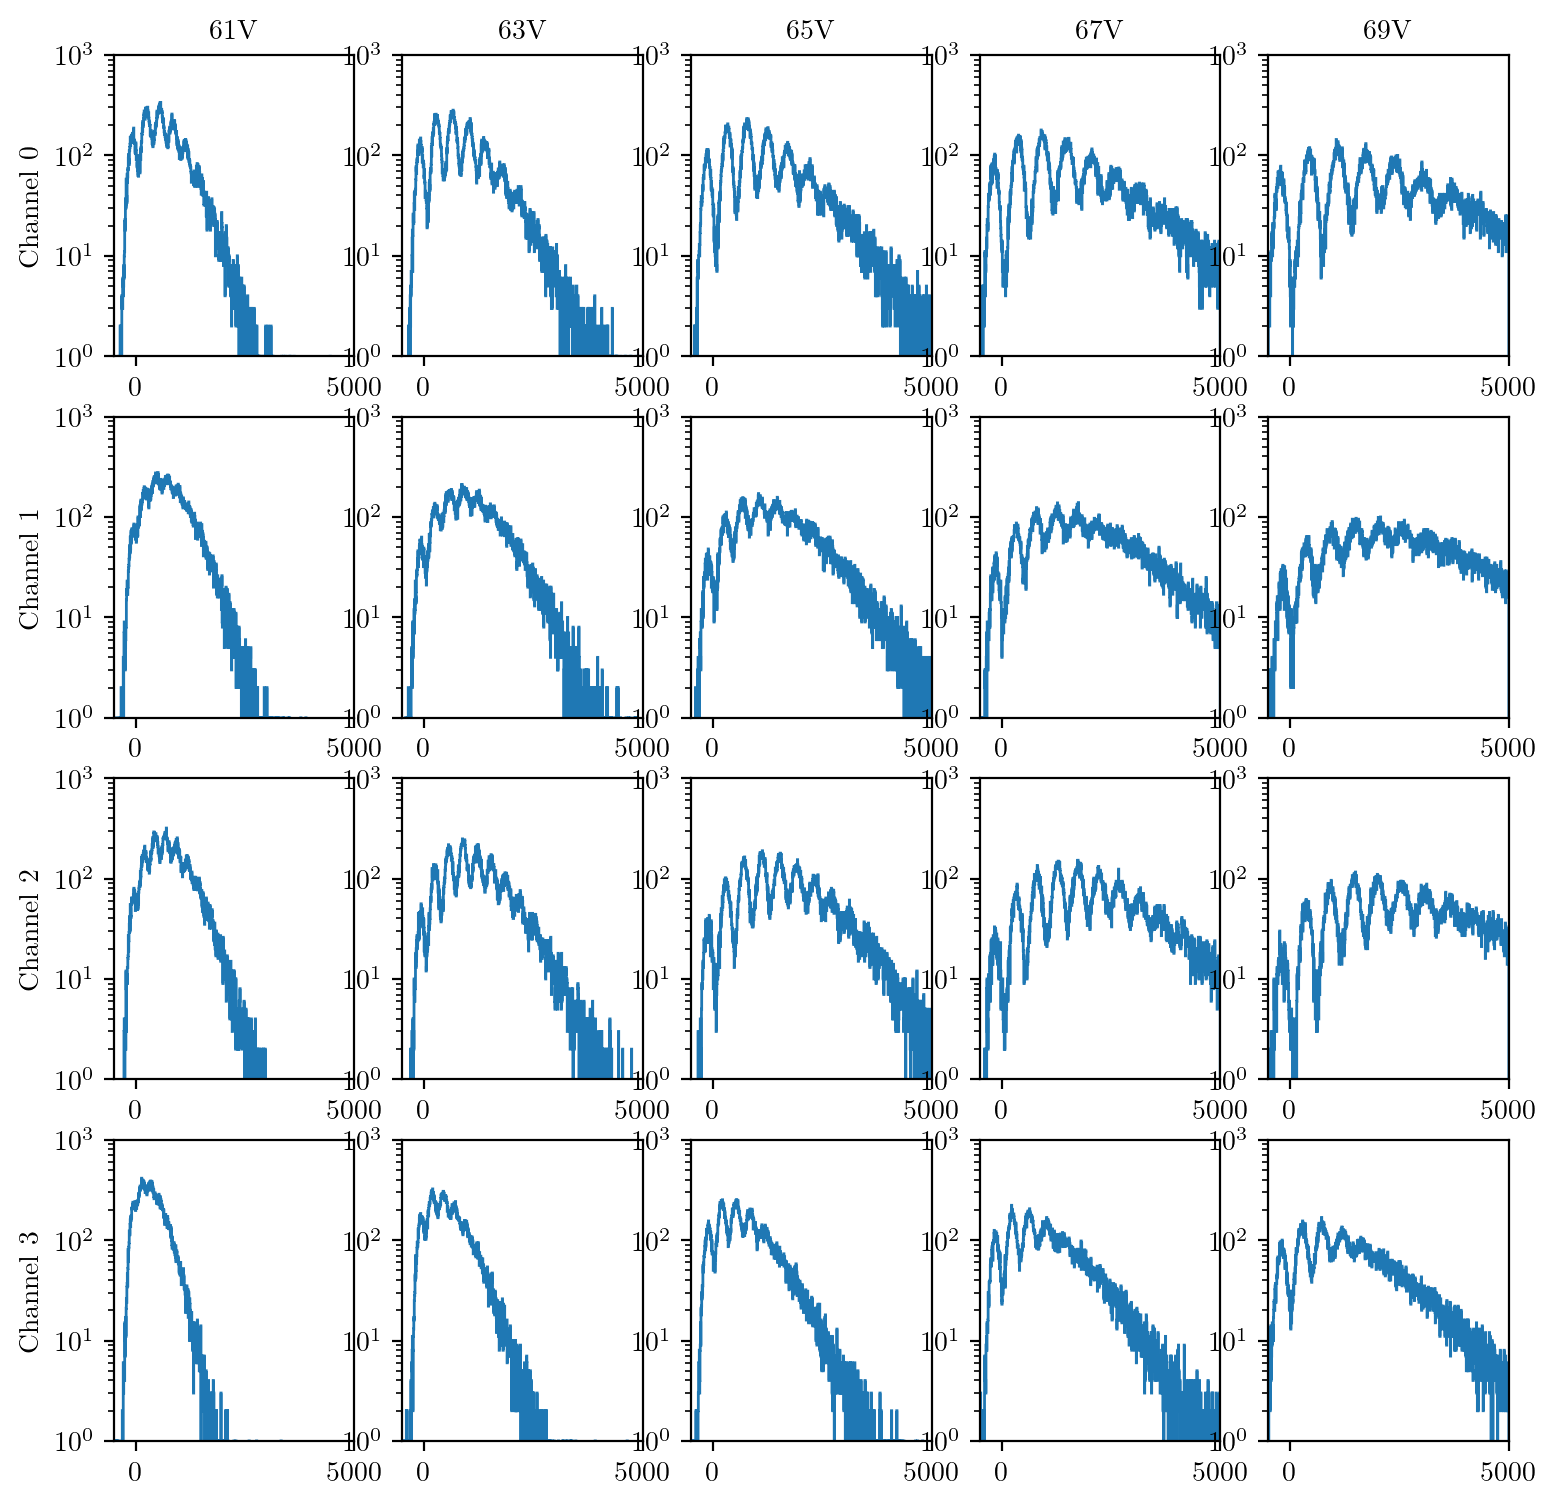

In [13]:
plt.figure(0,figsize=(9,9)) #for charge histograms
# plt.figure(1,figsize=(9,3)) #for breakdown voltage fit
# Vbd_charge_plt.figure(0,figsize=(9,9)) #for charge histograms
# plt.figure(1,figsize=(9,3)) #for breakdown voltage fit
# Vbd_charge_bot = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets_bot):
        #charge histogram
        data.ch[ch].get_integral_hist(short=[-5e2,5e3,1000], long=[-5e2,5e3,1000])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].integral_short_hist, data.ch[ch].integral_short_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].integral_short_hist_bin[0], data.ch[ch].integral_short_hist_bin[-1])
        plt.ylim(1, 1e3)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='integral_short', thre=100, prom=10, wid=10, dist=10)
        # fit pe peaks with Gaussian
        # min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='integral_short')
        # npe = len(data.ch[ch].integral_short_hist_fit)
        # for ipe in range(npe):
        #     popt = [data.ch[ch].integral_short_hist_fit[ipe][ipar][0] for ipar in range(3)]
        #     plt.plot(data.ch[ch].integral_short_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].integral_short_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
        #fit pe-mean vs pe with linear
        # Ishort = [[data.ch[ch].integral_short_hist_fit[k][1][0], data.ch[ch].integral_short_hist_fit[k][1][1]] for k in range(npe)]
        # xlin = np.linspace(1,npe,npe)
        # ylin = np.array(Ishort)[:,0]
        # popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Ishort)[:,1], maxfev=10000)
    #breakdown voltage fit and plot
    # xlin = bias
    # ylin = [data.ch[ch].gain_integral[0] for data in datasets_bot]
    # err = [data.ch[ch].gain_integral[1] for data in datasets_bot]
    # popt,pcov = curve_fit(line_vbd, xlin, ylin, p0=[20, 55], sigma=err, maxfev=10000)
    # print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    # Vbd_charge_bot[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    # plt.figure(1)
    # plt.subplot(1,4,ch+1)
    # plt.title('Channel {}'.format(ch))
    # plt.ylabel('Gain (A.U.)')
    # plt.xlabel('Bias (V)')
    # plt.errorbar(xlin,ylin,yerr=err,fmt='o',markersize=2)
    # plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    # plt.xlim(50,80)
    # plt.ylim(0,1000)

## Plot filtered amplitude histogram and analyze

mu=2.129 p=0.083
mu=2.367 p=0.124
mu=2.551 p=0.166
mu=2.595 p=0.233
mu=2.699 p=0.316
Channel 0 Vbd=55.103+/-0.048V slope=8.965+/-0.042
mu=3.032 p=0.082
mu=3.486 p=0.098
mu=3.660 p=0.156
mu=3.915 p=0.142
mu=4.085 p=0.308
Channel 1 Vbd=54.890+/-0.129V slope=8.519+/-0.117
mu=3.073 p=0.076
mu=3.448 p=0.114
mu=3.658 p=0.162
mu=3.806 p=0.205
mu=3.885 p=0.274
Channel 2 Vbd=55.242+/-0.161V slope=8.117+/-0.124
mu=1.953 p=0.070
mu=2.129 p=0.118
mu=2.300 p=0.161
mu=2.386 p=0.213
mu=2.440 p=0.283
Channel 3 Vbd=55.182+/-0.021V slope=7.392+/-0.015


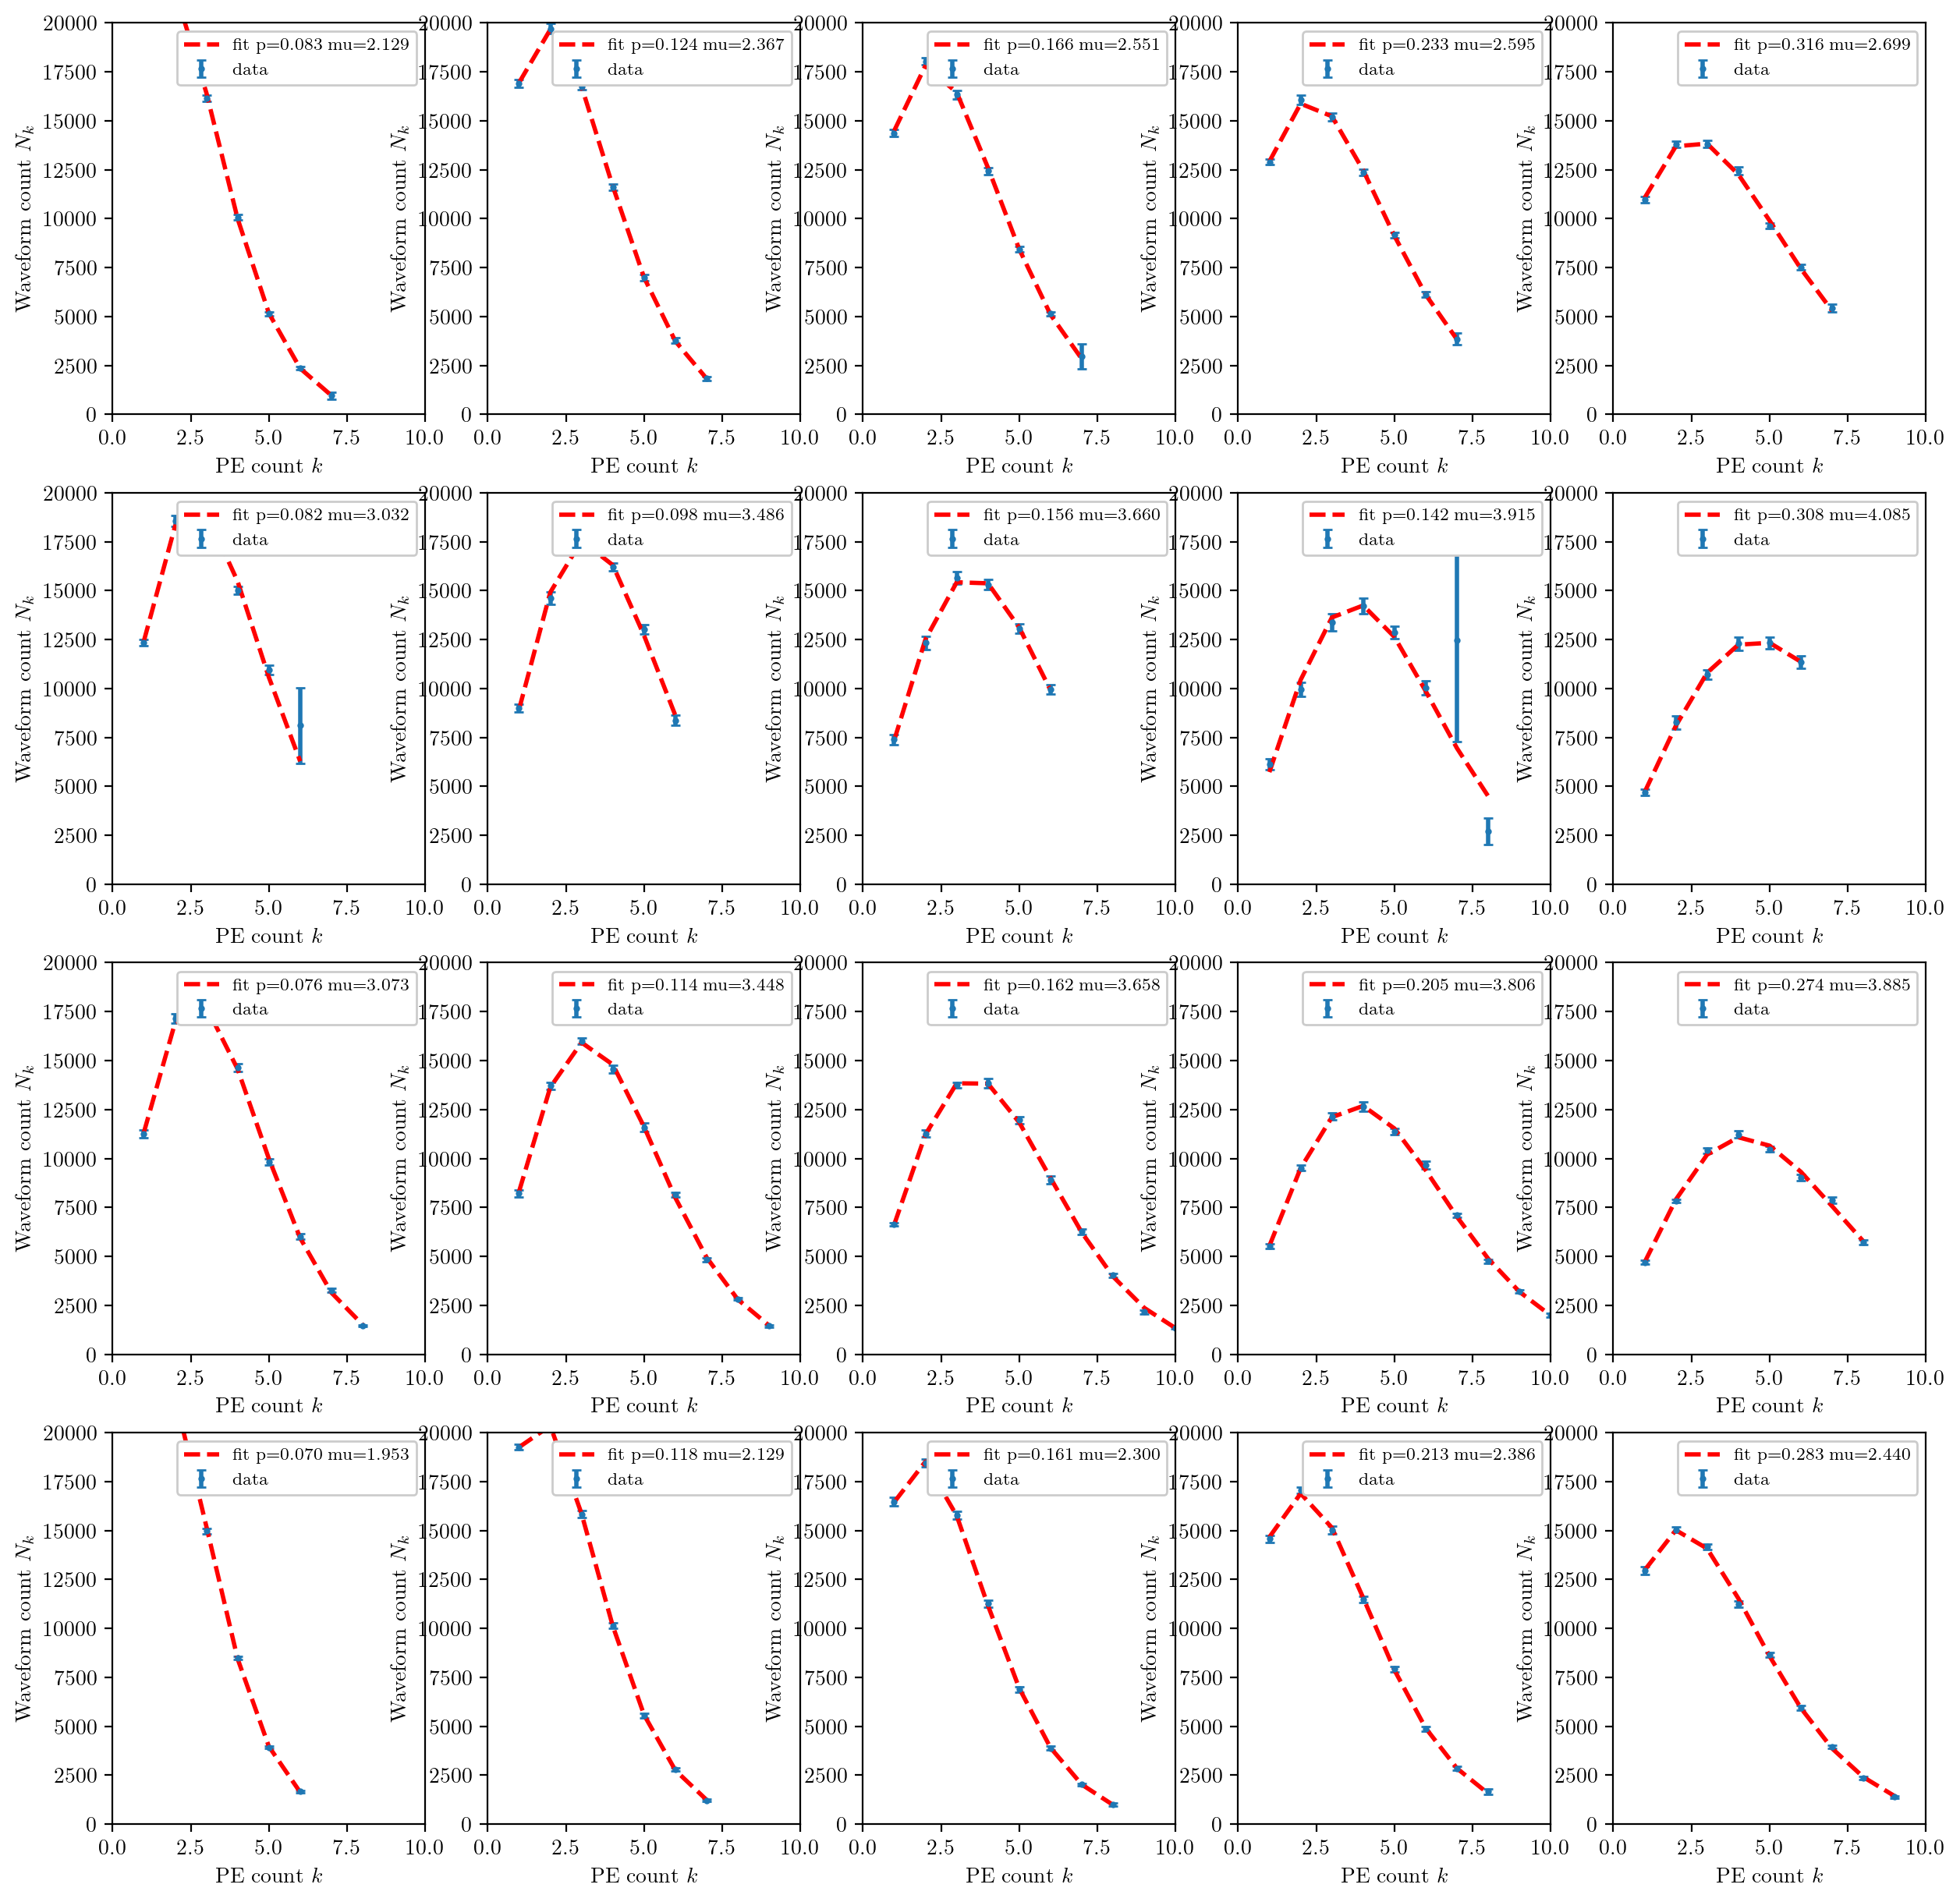

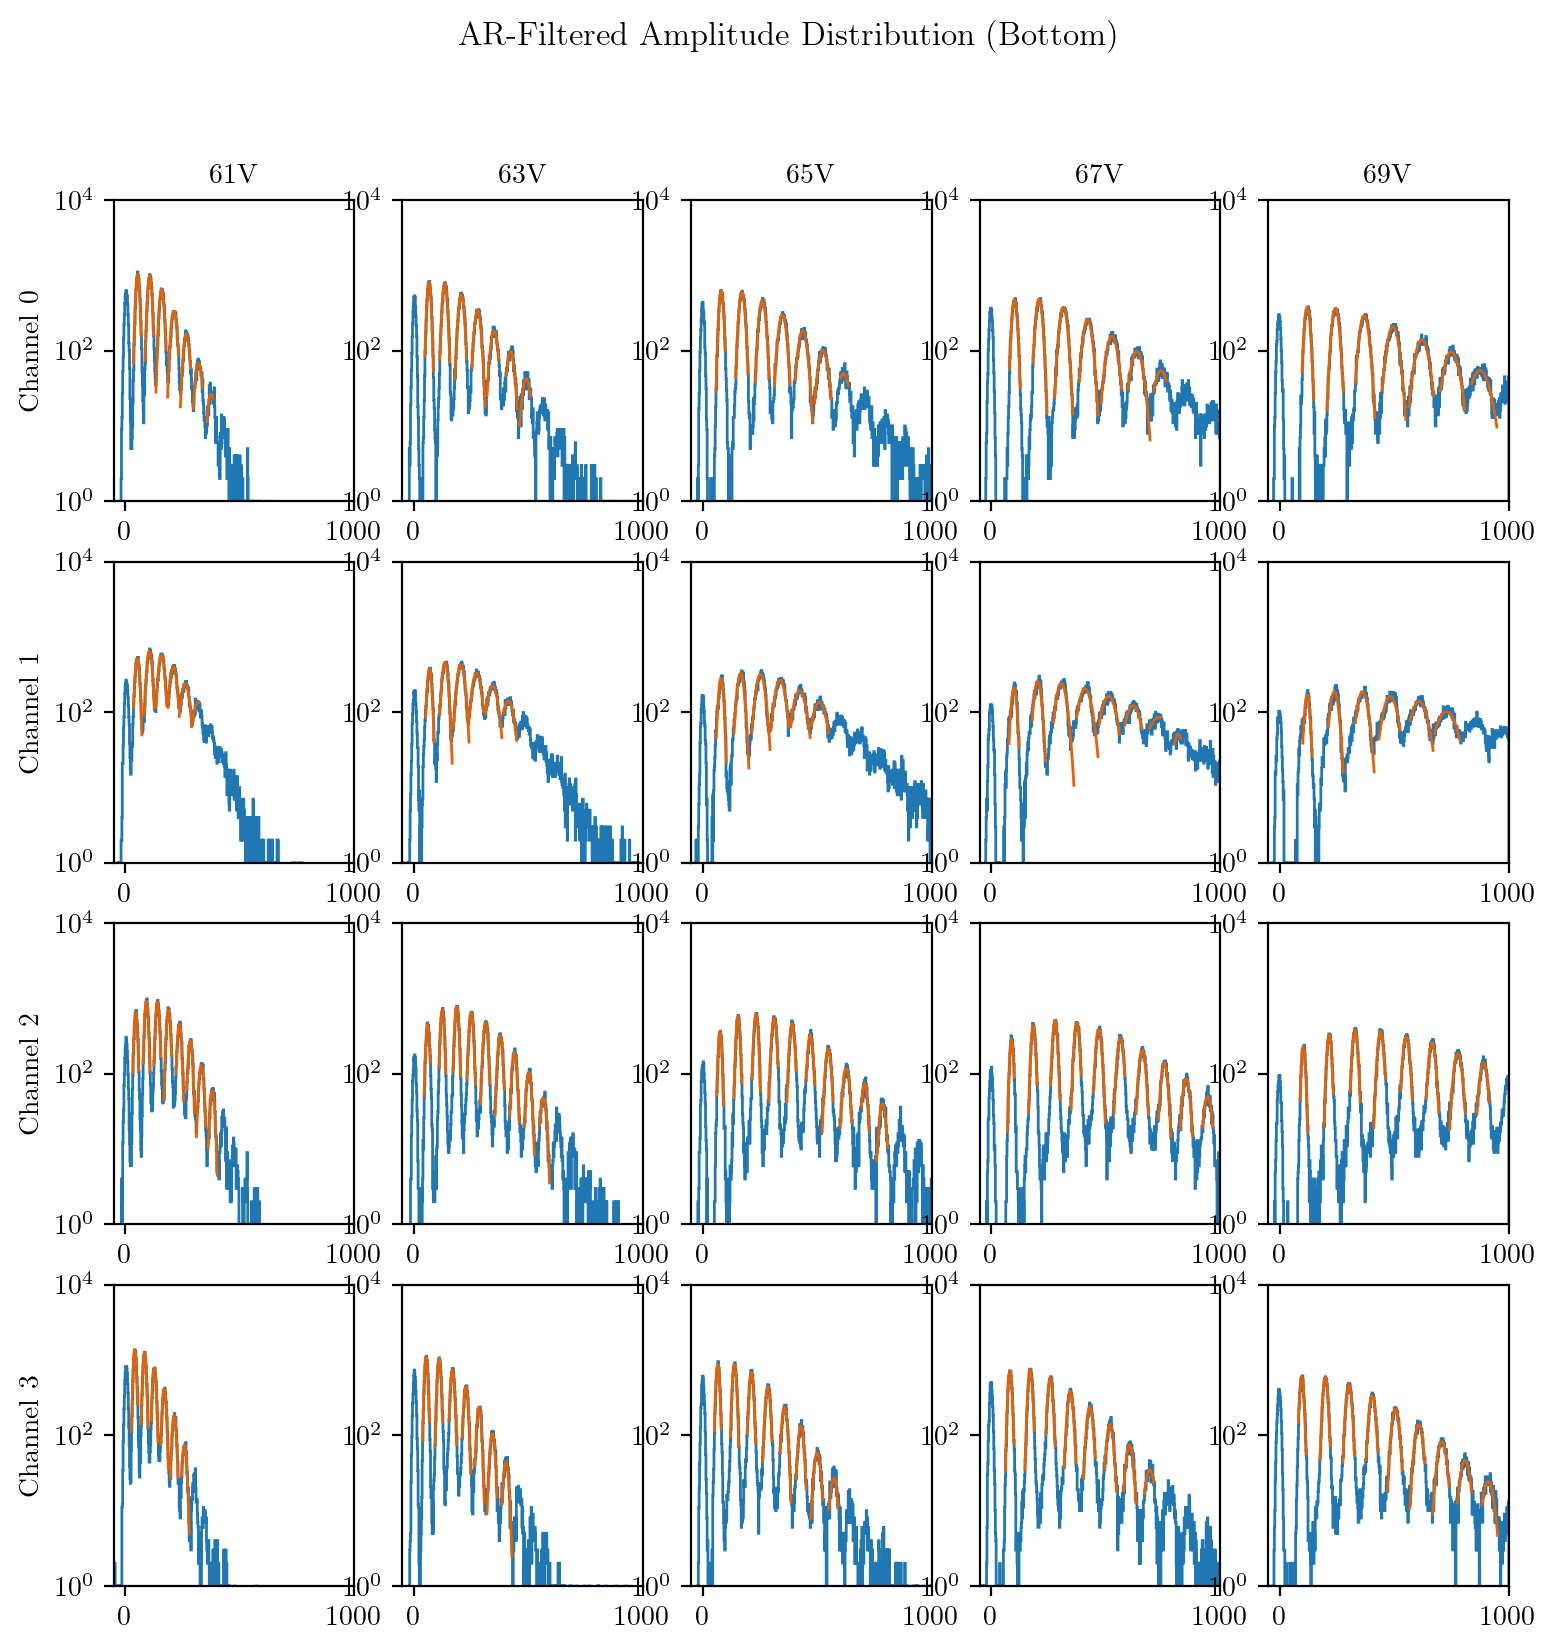

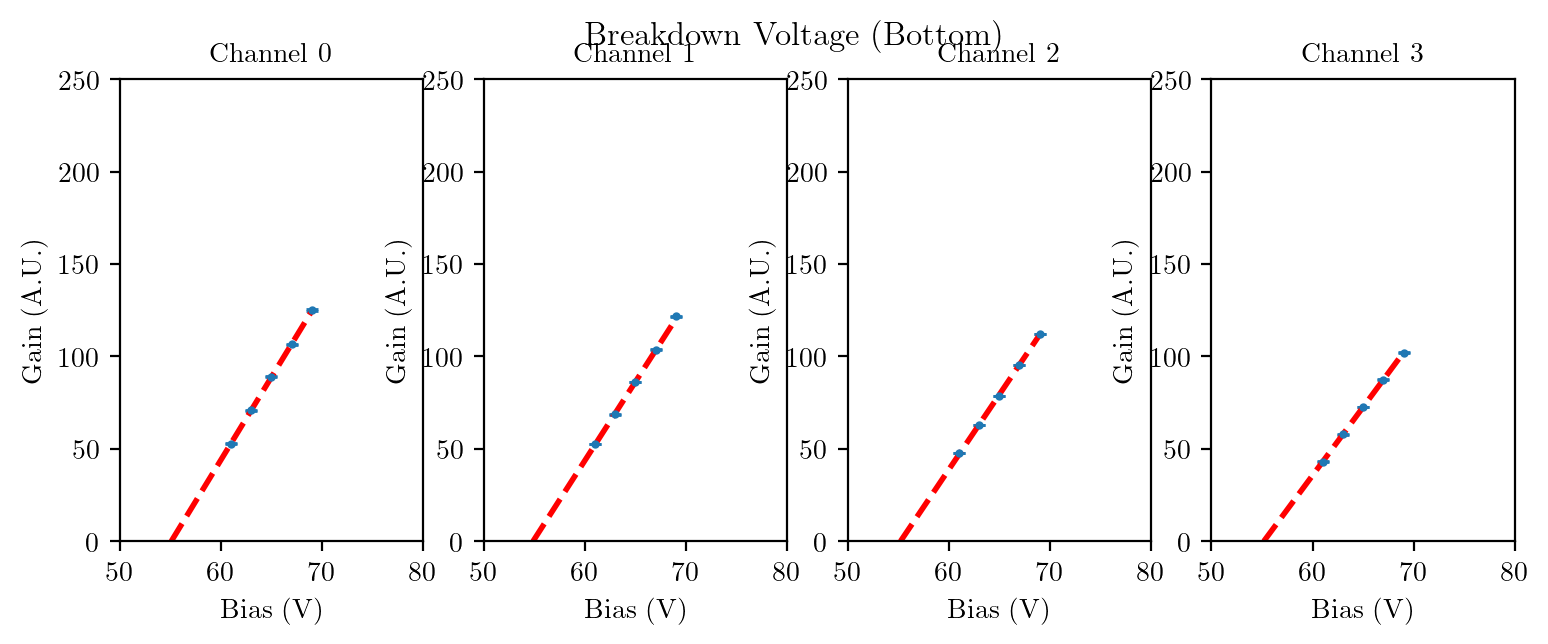

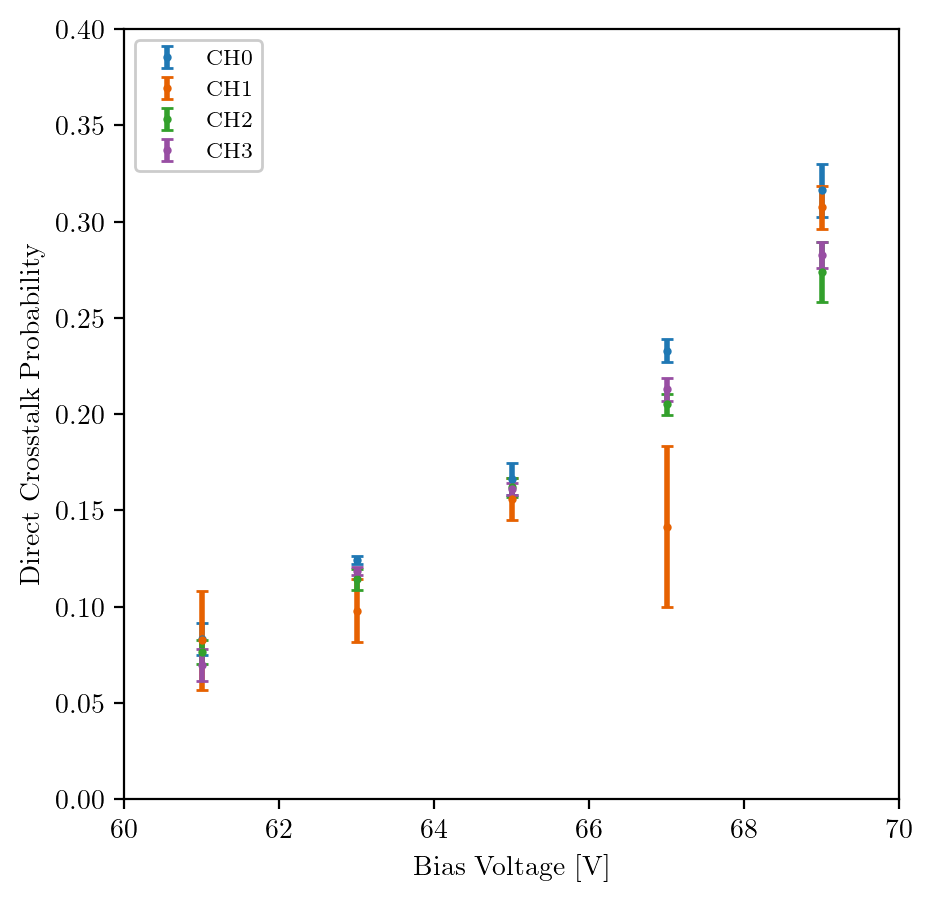

In [14]:
plt.figure(0,figsize=(9,9)) # for filtered amplitude histograms
plt.figure(1,figsize=(9,3)) # for breakdown voltage fit
plt.figure(2,figsize=(15,15)) # for Vinogradov fit
plt.figure(3,figsize=(5,5)) # for crosstalk summary
Vbd_famp_bot = np.zeros((4,2))
for ch in range(4):
    for i,data in enumerate(datasets_bot):  
        #filtered amplitude histogram
        data.ch[ch].get_famp_hist(bin=[-50,1e3,600])
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.stairs(data.ch[ch].famp_hist, data.ch[ch].famp_hist_bin)
        plt.yscale('log')
        plt.xlim(data.ch[ch].famp_hist_bin[0], data.ch[ch].famp_hist_bin[-1])
        plt.ylim(1, 1e4)
        # find pe peaks in histograms
        data.ch[ch].find_histo_peaks(hist='famp', thre=40, prom=30, wid=8, dist=8)
        # fit pe peaks with Gaussian
        min_bins, max_bins = data.ch[ch].fit_histo_peaks(hist='famp')
        npe = len(data.ch[ch].famp_hist_fit)
        for ipe in range(npe):
            popt = [data.ch[ch].famp_hist_fit[ipe][ipar][0] for ipar in range(3)]
            plt.plot(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], gauss(data.ch[ch].famp_hist_bin[min_bins[ipe]:max_bins[ipe]], *popt), color=colors[1], lw=1, zorder=10)
        #fit pe-mean vs pe with linear
        Afilt = [[data.ch[ch].famp_hist_fit[k][1][0], data.ch[ch].famp_hist_fit[k][1][1]] for k in range(npe)]
        xlin = np.linspace(1,npe,npe)
        ylin = np.array(Afilt)[:,0]
        popt,pcov = curve_fit(line, xlin, ylin, p0=[100, 0], sigma=np.array(Afilt)[:,1], maxfev=10000)          
        data.ch[ch].set_spe_gain(q_a=[popt[0], np.sqrt(pcov[0,0])]) # This is Q_A
        #Vinogradov fit
        plt.figure(2)
        plt.subplot(4,5,ch*5+i+1)
        N_k = [data.ch[ch].famp_hist_fit[k][0] for k in range(npe)]
        plt.errorbar(np.arange(1,len(N_k)+1), np.array(N_k)[:,0], yerr=np.array(N_k)[:,1], fmt='o', markersize=2, label='data')
        popt,pcov = curve_fit(compound_poisson, list(np.arange(1,len(N_k)+1)), np.array(N_k)[:,0], p0=[data.ch[ch].nevents, 5, 0.2], sigma=np.array(N_k)[:,1], maxfev=10000)
        print('mu={:.3f} p={:.3f}'.format(popt[1], popt[2]))
        data.ch[ch].set_correlated_noise(ct=[popt[2],np.sqrt(pcov[2,2])])
        plt.plot(np.arange(1,len(N_k)+1), compound_poisson(np.arange(1,len(N_k)+1),*popt), 'r--', label='fit p={:.3f} mu={:.3f}'.format(popt[2],popt[1]))
        plt.ylim(0,0.4*data.ch[ch].nevents)
        plt.xlim(0,10)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'Waveform count $N_k$')
        plt.legend(loc='upper right')
    # plot crosstalk
    plt.figure(3)
    plt.errorbar(bias, [data.ch[ch].ct[0] for data in datasets_bot], yerr=[data.ch[ch].ct[1] for data in datasets_bot], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_a[0] for data in datasets_bot]
    err = [data.ch[ch].q_a[1] for data in datasets_bot]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[20, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_famp_bot[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(1)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel('Gain (A.U.)')
    plt.xlabel('Bias (V)')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,250)
        

plt.figure(0)
plt.suptitle('AR-Filtered Amplitude Distribution (Bottom)')
plt.savefig('plots/sipm/famp_histo_bot_1101.pdf')
plt.figure(1)
plt.suptitle('Breakdown Voltage (Bottom)')
plt.savefig('plots/sipm/gain_bias_famp_bot_1101.pdf')
plt.figure(3)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Direct Crosstalk Probability')
plt.xlim(60,70)
plt.ylim(0, 0.4)
plt.savefig('plots/sipm/dict_bot_1101.pdf')

## Afterpulsing


Channel 0 Vbd=54.076+/-0.260V slope=47.569+/-1.137
Channel 1 Vbd=53.708+/-0.304V slope=45.053+/-1.126


/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:803: RuntimeWarning: divide by zero encountered in divide
  transform = 1.0 / sigma
/home/as111/.conda/envs/ds-pu/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Channel 2 Vbd=53.759+/-0.295V slope=44.898+/-1.177
Channel 3 Vbd=54.528+/-0.298V slope=43.710+/-1.237


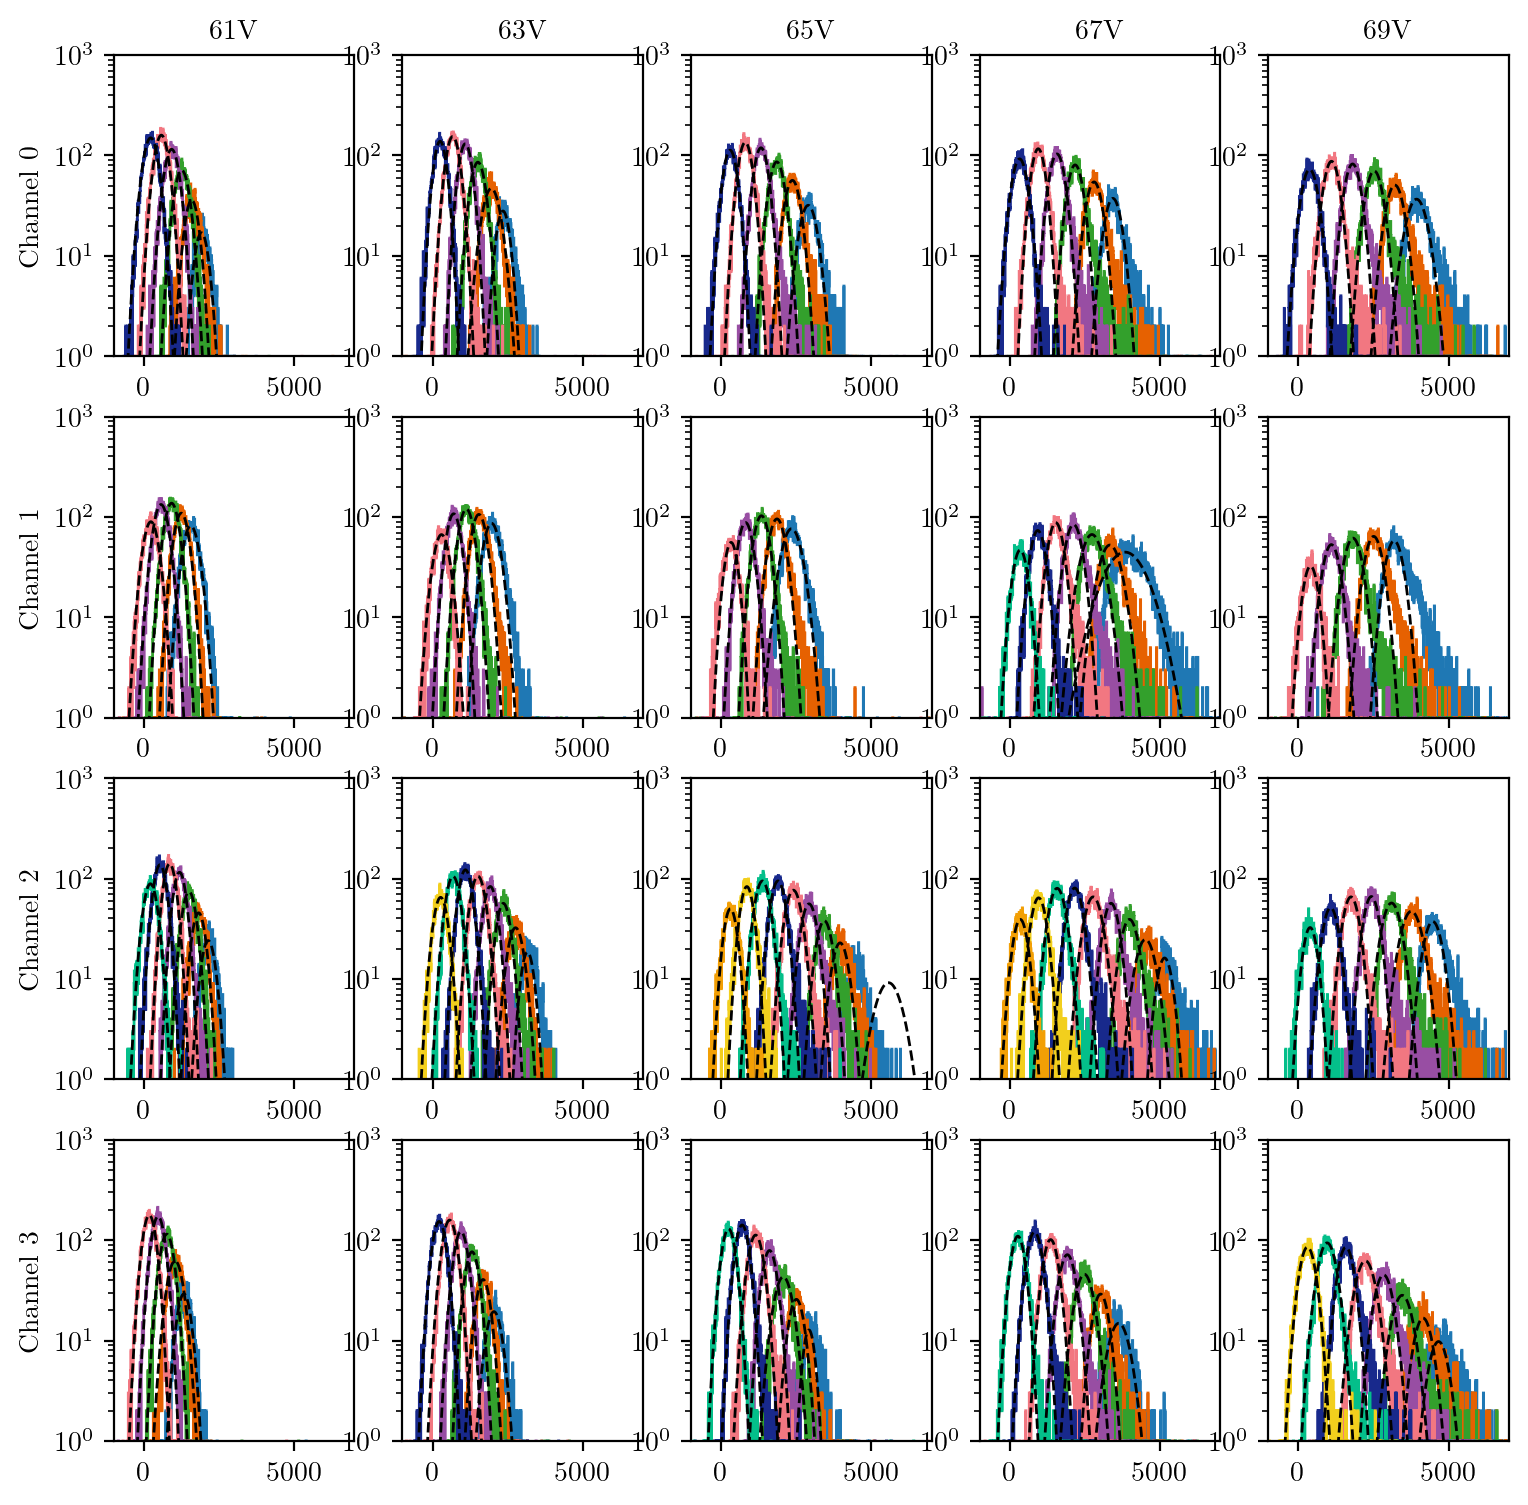

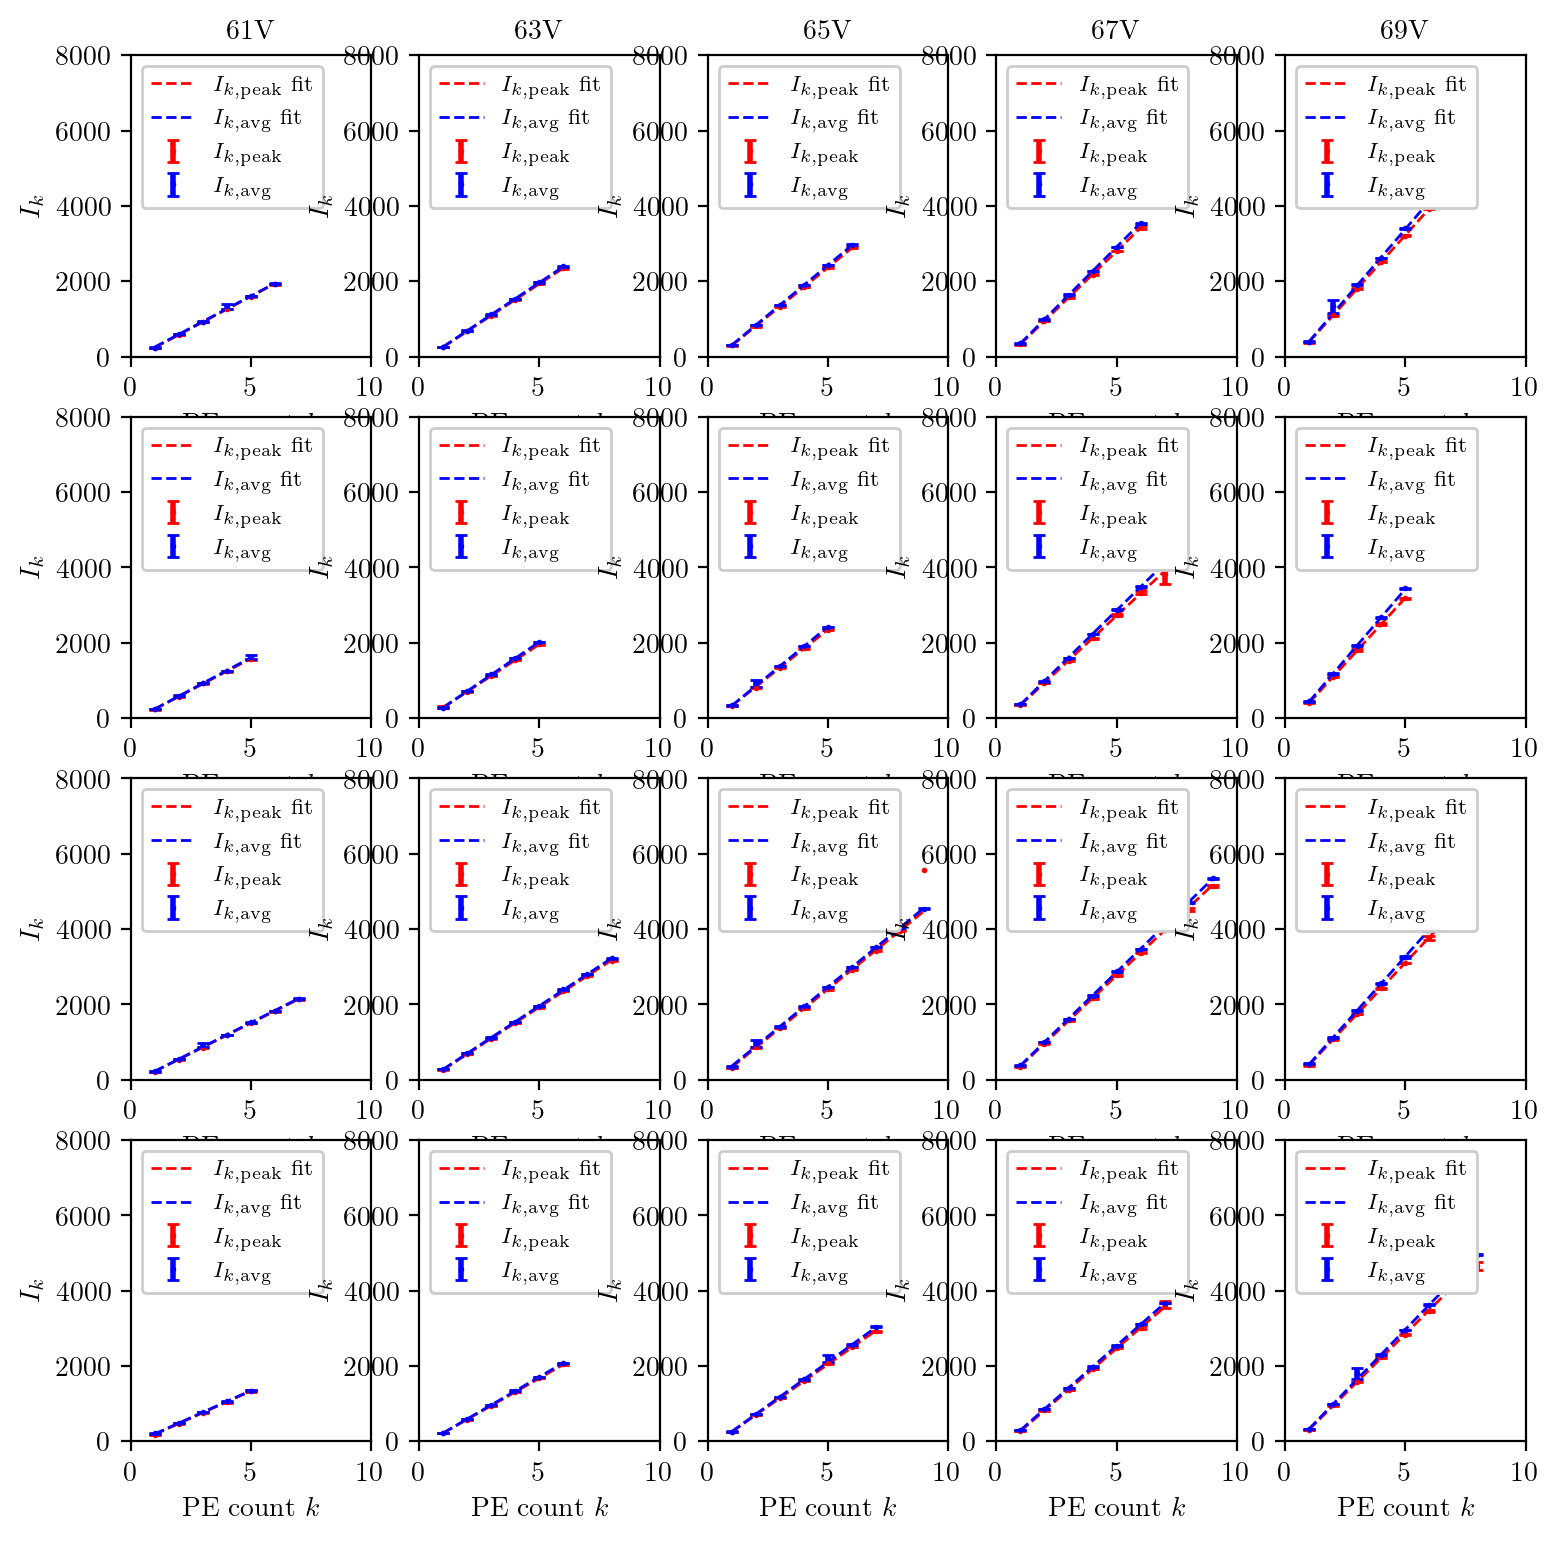

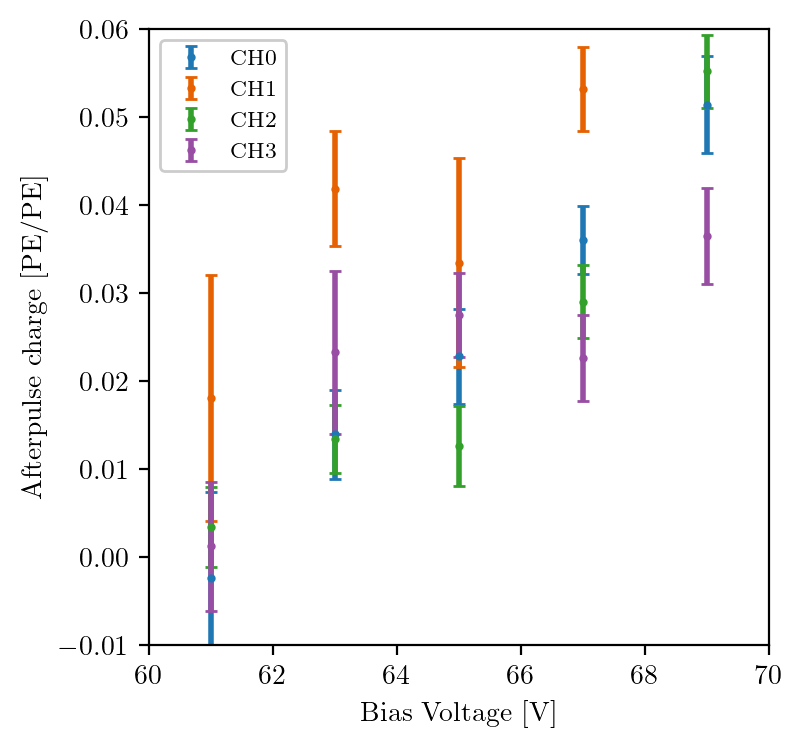

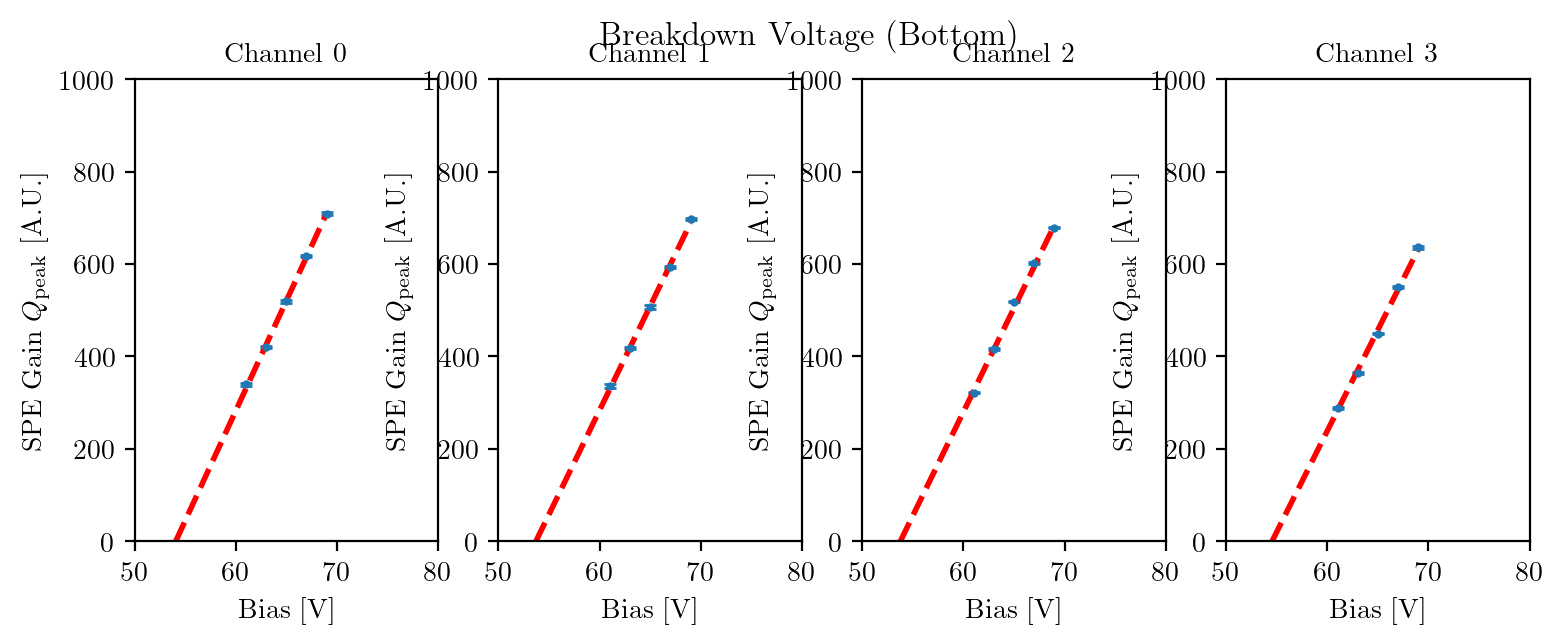

In [15]:
plt.figure(0,figsize=(9,9)) # for I_k histograms
plt.figure(1,figsize=(9,9)) # for I_k fits
plt.figure(2,figsize=(4,4)) # for afterpulse
plt.figure(3,figsize=(9,3)) # for Vbd
Vbd_charge_bot = np.zeros((4,2))
x_min=-1000
x_max=7000
n_bins=1000
bin_width = (x_max-x_min)/n_bins
for ch in range(4):
    for i,data in enumerate(datasets_bot):
        Ik_peak = [] 
        Ik_avg = []
        data.ch[ch].get_afterpulse_charge(nsigma=2, bin=[x_min, x_max, n_bins])
        #histogram and Gaussian fit
        plt.figure(0)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        for j in np.arange(len(data.ch[ch].ap_charge)-2,-1,-1):
            plt.stairs(data.ch[ch].ap_charge_hist[j], data.ch[ch].ap_charge_hist_bin[j])
            Ik_avg.append([np.mean(data.ch[ch].ap_charge[j]), np.std(data.ch[ch].ap_charge[j])/np.sqrt(len(data.ch[ch].ap_charge[j]))])
            w = int(np.std(data.ch[ch].ap_charge[j])/bin_width) # in bins
            p = np.argmax(data.ch[ch].ap_charge_hist[j]) # in bins
            if w>0.1*(p+x_min/bin_width):
                w=30 # something weird happened so I need to do this
            popt,pcov = curve_fit(gauss, data.ch[ch].ap_charge_hist_bin[j][p-w:p+w], data.ch[ch].ap_charge_hist[j][p-w:p+w], p0=[np.max(data.ch[ch].ap_charge_hist[j])*w*bin_width,p*bin_width,w*bin_width], sigma=np.sqrt(data.ch[ch].ap_charge_hist[j][p-w:p+w]), maxfev=100000)
            plt.plot(data.ch[ch].ap_charge_hist_bin[j][:-1], gauss(data.ch[ch].ap_charge_hist_bin[j][:-1], *popt), 'k--', linewidth=1)
            Ik_peak.append([popt[1],np.sqrt(pcov[1,1])])
        plt.xlim(data.ch[ch].ap_charge_hist_bin[0][0], data.ch[ch].ap_charge_hist_bin[0][-1])
        plt.ylim(1,1e3)
        plt.yscale('log')
        # plot mu-pe vs avg-pe
        Ik_peak = list(reversed(Ik_peak))
        Ik_avg = list(reversed(Ik_avg))
        plt.figure(1)
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        # Q_peak fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], yerr=np.array(Ik_peak)[:,1], fmt='r.', markersize=2, label=r'$I_{k,\rm peak}$')
        popt,pcov=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_peak)[:,0], p0=[500,0], sigma=np.array(Ik_peak)[:,1], maxfev=10000)
        # print('Q_peak = {:.3f}+/-{:.3f}'.format(popt[0], np.sqrt(pcov[0,0])))
        data.ch[ch].set_spe_gain(q_peak=[popt[0],np.sqrt(pcov[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt), 'r--', label=r'$I_{k,\rm peak}$ fit', linewidth=1)
        # Q_avg fit
        plt.errorbar(np.arange(len(data.ch[ch].ap_charge)-1)+1, np.array(Ik_avg)[:,0], yerr=np.array(Ik_avg)[:,1], fmt='b.', markersize=2, label=r'$I_{k,\rm avg}$')
        popt_,pcov_=curve_fit(line,np.arange(len(data.ch[ch].ap_charge)-1)+1,np.array(Ik_avg)[:,0], p0=[500,0], sigma=np.array(Ik_avg)[:,1], maxfev=10000)
        # print('Q_avg = {:.3f}+/-{:.3f}'.format(popt_[0], np.sqrt(pcov_[0,0])))
        data.ch[ch].set_spe_gain(q_avg=[popt_[0],np.sqrt(pcov_[0,0])])
        plt.plot(np.arange(len(data.ch[ch].ap_charge)-1)+1, line(np.arange(len(data.ch[ch].ap_charge)-1)+1, *popt_), 'b--', label=r'$I_{k,\rm avg}$ fit', linewidth=1)
        plt.xlabel(r'PE count $k$')
        plt.ylabel(r'$I_k$')
        data.ch[ch].set_correlated_noise(ap=[popt_[0]/popt[0]-1, popt_[0]/popt[0]*np.sqrt(pcov[0,0]/popt[0]**2+pcov_[0,0]/popt_[0]**2)])
        plt.xlim(0,10)
        plt.ylim(0,8000)
        plt.legend()
    # plot after-pulses
    plt.figure(2)
    plt.errorbar(bias, [data.ch[ch].ap[0] for data in datasets_bot], yerr=[data.ch[ch].ap[1] for data in datasets_bot], label='CH{}'.format(ch), fmt='o', markersize=2)

    #breakdown voltage fit and plot
    xlin = bias
    ylin = [data.ch[ch].q_peak[0] for data in datasets_bot]
    err = [data.ch[ch].q_peak[1] for data in datasets_bot]
    popt,pcov = curve_fit(line_vbd, xlin, ylin, sigma=err, p0=[100, 55], maxfev=10000)
    print("Channel {} Vbd={:.3f}+/-{:.3f}V slope={:.3f}+/-{:.3f}".format(ch,popt[1],np.sqrt(pcov[1,1]),popt[0],np.sqrt(pcov[0,0])))
    Vbd_charge_bot[ch,:] = np.array([popt[1],np.sqrt(pcov[1,1])])
    plt.figure(3)
    plt.subplot(1,4,ch+1)
    plt.title('Channel {}'.format(ch))
    plt.ylabel(r'SPE Gain $Q_{\rm peak}$ [A.U.]')
    plt.xlabel('Bias [V]')
    plt.errorbar(xlin,ylin,yerr=err,fmt='o', markersize=2)
    plt.plot(sorted(xlin+[popt[1]]),line_vbd(np.array(sorted(xlin+[popt[1]])),*popt),'r--')
    plt.xlim(50,80)
    plt.ylim(0,1000)

plt.figure(2)
plt.legend()
plt.xlabel('Bias Voltage [V]')
plt.ylabel('Afterpulse charge [PE/PE]')
plt.xlim(60,70)
plt.ylim(-0.01, 0.06)
plt.savefig('plots/sipm/afterpulse_bias_bot_1101.pdf')
plt.figure(3)
plt.suptitle('Breakdown Voltage (Bottom)')
plt.savefig('plots/sipm/gain_bias_charge_bot_1101.pdf')

# Breakdown voltage summary

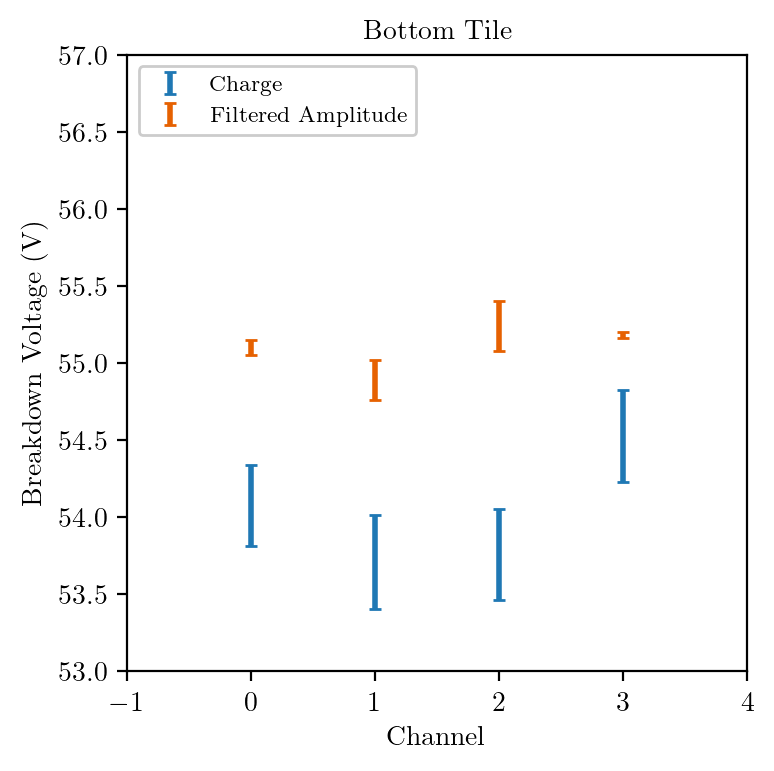

<Figure size 800x600 with 0 Axes>

In [16]:
plt.figure(0,figsize=(4,4))
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_charge_bot[:,0], yerr=Vbd_charge_bot[:,1], label='Charge', ls='none')
plt.errorbar(x=np.linspace(0,3,4), y=Vbd_famp_bot[:,0], yerr=Vbd_famp_bot[:,1], label='Filtered Amplitude', ls='none')
plt.xlim(-1,4)
plt.ylim(53,57)
plt.xlabel('Channel')
plt.ylabel('Breakdown Voltage (V)')
plt.title('Bottom Tile')
plt.legend()
plt.show()
plt.savefig('plots/sipm/vbd_bot_1101.pdf')

## SPE average waveform

CH0 61V  A1=2.020+/-0.031 TAU1=0.4587+/-0.0061us A2=2.309+/-0.048 TAU2=0.0561+/-0.0023us sigma=0.0068+/-0.0002us t0=6.326+/-0.000us
CH0 63V  A1=2.404+/-0.032 TAU1=0.4304+/-0.0051us A2=3.120+/-0.050 TAU2=0.0536+/-0.0017us sigma=0.0070+/-0.0002us t0=6.327+/-0.000us
CH0 65V  A1=3.159+/-0.034 TAU1=0.3970+/-0.0038us A2=4.072+/-0.065 TAU2=0.0450+/-0.0013us sigma=0.0074+/-0.0002us t0=6.327+/-0.000us
CH0 67V  A1=3.865+/-0.044 TAU1=0.3710+/-0.0038us A2=5.457+/-0.078 TAU2=0.0449+/-0.0012us sigma=0.0075+/-0.0001us t0=6.328+/-0.000us
CH0 69V  A1=5.036+/-0.059 TAU1=0.3416+/-0.0034us A2=5.478+/-0.090 TAU2=0.0456+/-0.0015us sigma=0.0075+/-0.0002us t0=6.328+/-0.000us
CH1 61V  A1=0.621+/-0.024 TAU1=0.9050+/-0.0345us A2=3.459+/-0.029 TAU2=0.1088+/-0.0020us sigma=0.0065+/-0.0002us t0=6.326+/-0.000us
CH1 63V  A1=0.777+/-0.030 TAU1=0.8624+/-0.0317us A2=4.667+/-0.036 TAU2=0.1051+/-0.0017us sigma=0.0064+/-0.0002us t0=6.327+/-0.000us
CH1 65V  A1=0.972+/-0.036 TAU1=0.8286+/-0.0288us A2=5.524+/-0.044 TAU2=0.102

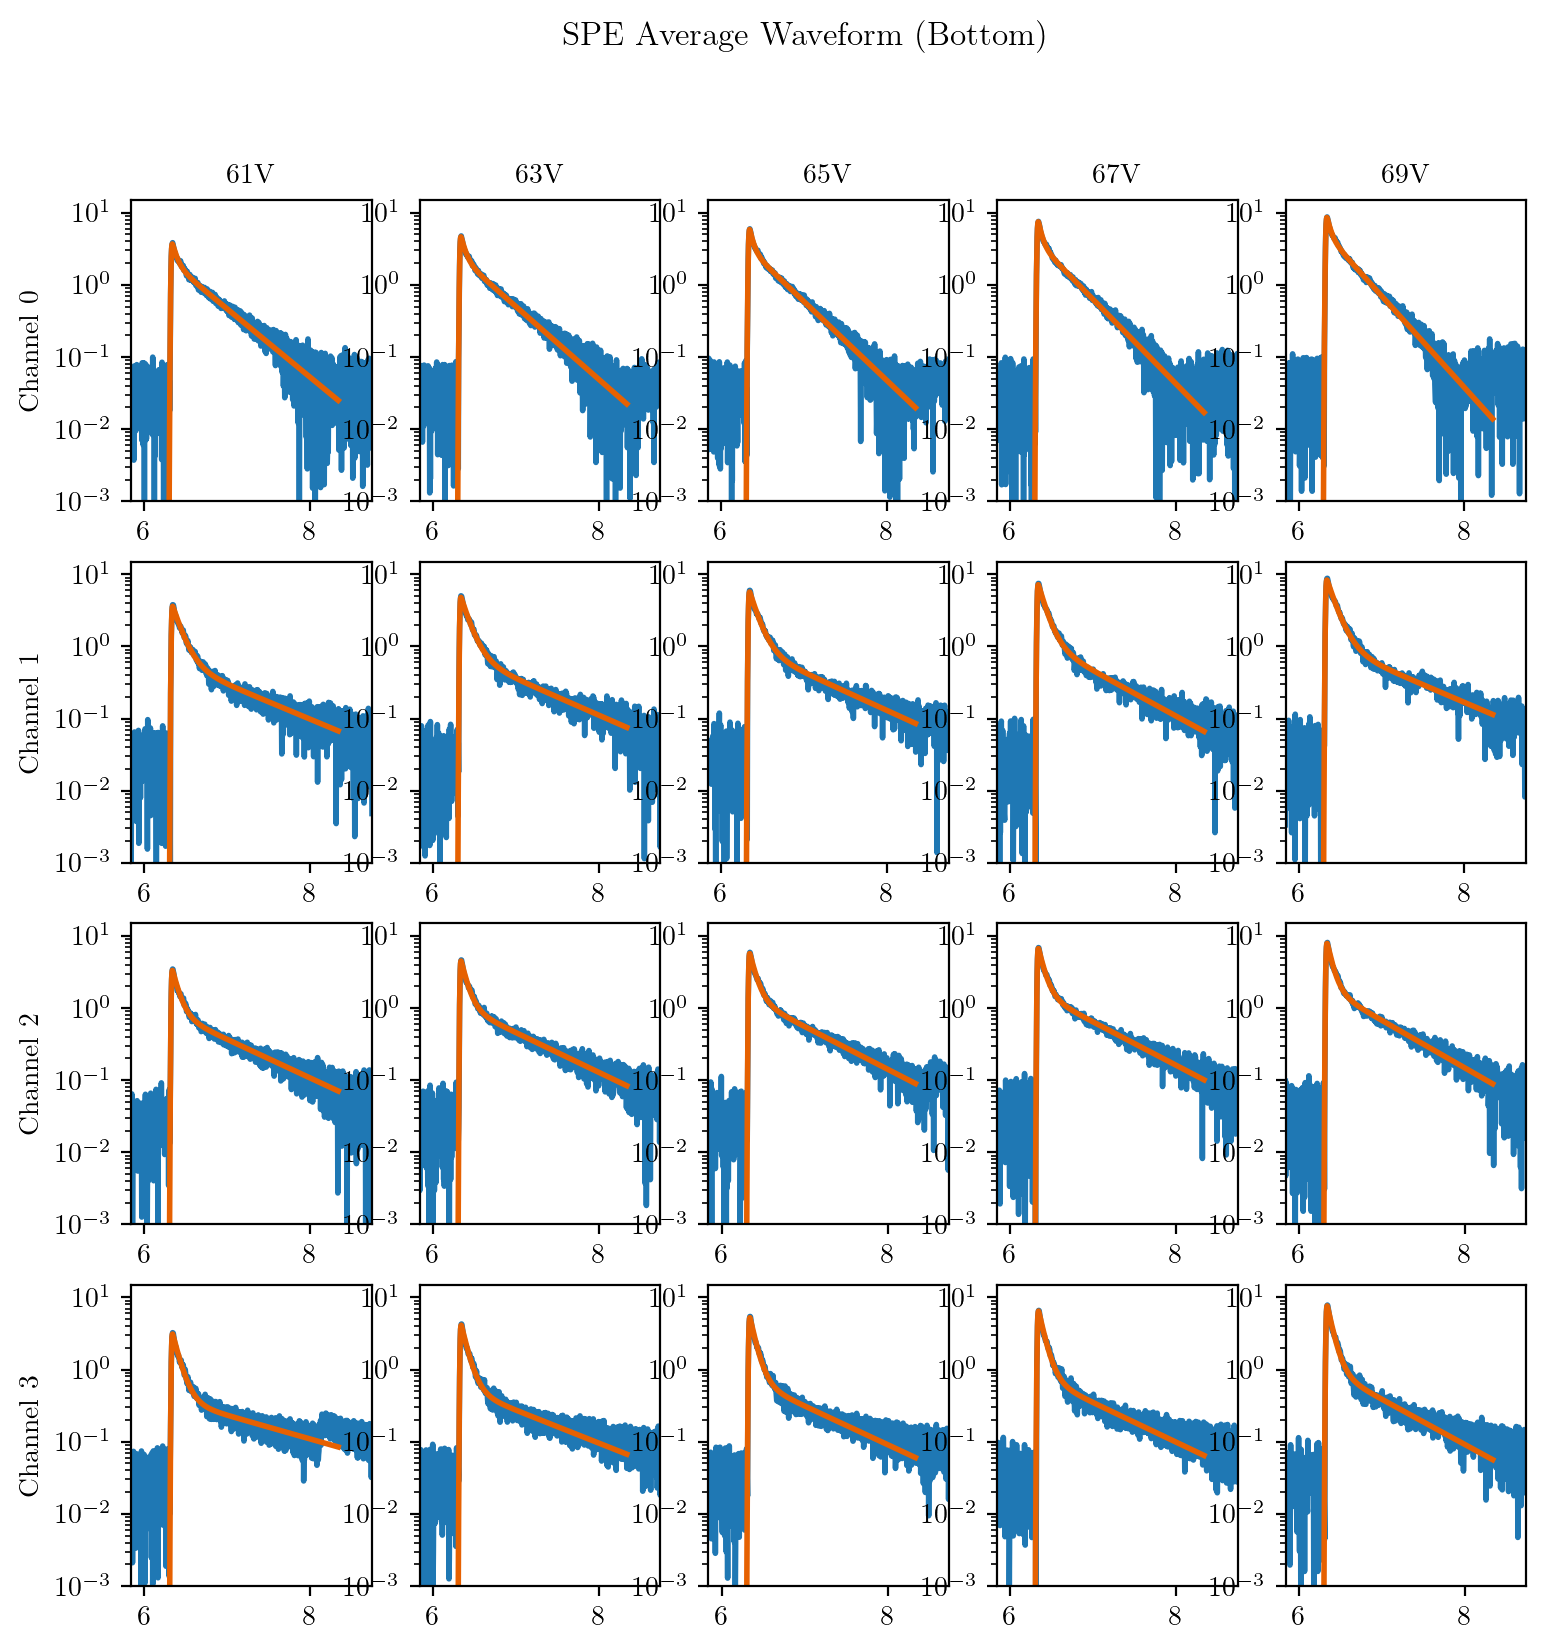

In [17]:
#for spe average waveforms
plt.figure(0,figsize=(9,9))
for ch in range(4):
    spe_integral = []
    for i,data in enumerate(datasets_bot):
        data.ch[ch].get_spe_avgwf()
        data.ch[ch].clear()
        plt.subplot(4,5,ch*5+i+1)
        if ch==0:
            plt.title('{:.0f}V'.format(bias[i]))
        if i==0:
            plt.ylabel('Channel {}'.format(ch))
        plt.plot(data.ch[ch].time, abs(data.ch[ch].spe_avgwf))
        err = np.std(data.ch[ch].spe_avgwf[:data.ch[ch].baseline_samples])
        t_start = int(data.ch[ch].trigger_position - 0.1/data.ch[ch].sample_step)
        t_end = int(data.ch[ch].trigger_position + 2/data.ch[ch].sample_step)
        popt,pcov = curve_fit(data.ch[ch].get_pulse_shape, data.ch[ch].time[t_start:t_end], data.ch[ch].spe_avgwf[t_start:t_end], p0=[4.8,0.25,4.0,0.02,0.008,6.33], sigma=[err]*len(data.ch[ch].time[t_start:t_end]), maxfev=10000)
        plt.plot(data.ch[ch].time[t_start:t_end], data.ch[ch].get_pulse_shape(data.ch[ch].time[t_start:t_end],*popt))
        print('CH{} {}V  A1={:.3f}+/-{:.3f} TAU1={:.4f}+/-{:.4f}us A2={:.3f}+/-{:.3f} TAU2={:.4f}+/-{:.4f}us sigma={:.4f}+/-{:.4f}us t0={:.3f}+/-{:.3f}us'.format(ch,bias[i],popt[0],np.sqrt(pcov[0,0]),popt[1],np.sqrt(pcov[1,1]),popt[2],np.sqrt(pcov[2,2]),popt[3],np.sqrt(pcov[3,3]),popt[4],np.sqrt(pcov[4,4]),popt[5],np.sqrt(pcov[5,5])))
        data.ch[ch].set_pulse_pars(a1=popt[0], tau1=popt[1], a2=popt[2], tau2=popt[3])
        plt.xlim((t_start-100)*data.ch[ch].sample_step,(t_end+100)*data.ch[ch].sample_step)
        plt.ylim(1e-3, 15)
        plt.yscale('log')
plt.suptitle('SPE Average Waveform (Bottom)')
plt.savefig('plots/sipm/spewf_bot_1101.pdf')

In [19]:
import csv
for i,v in enumerate(bias):
    with open('pulse_parameters_{}V.csv'.format(v), 'w') as f:
        w = csv.writer(f)
        w.writerow(['CH', 'A1 [ADC count]', 'tau1 [us]', 'A2 [ADC count]', 'tau2 [us]'])
        for ch in range(4):
            w.writerow(['T{}'.format(ch)]+[str(par) for par in np.array(datasets_top[i].ch[ch].get_pulse_pars())[:]])
        for ch in range(4):
            w.writerow(['B{}'.format(ch)]+[str(par) for par in np.array(datasets_bot[i].ch[ch].get_pulse_pars())[:]])